In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP, RANDOM_SEED, FOLDER_DATA_AUGMENTATION,, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FOLDER_MODELS = '../models/autoencoders_requirements/'
FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'

In [3]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [4]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    if len(np.unique(y)) == 1:
        print(f"the requirement {name} has only one label.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [5]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [6]:
_, _, x, mrks = pkl.load(open(FILE_DUMP, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 11s 2ms/step - loss: 0.5320 - accuracy: 0.6564 - precision: 0.9435 - recall: 0.6342 - f1: 0.7491 - specificity: 0.7929 - negative_predictive_value: 0.2913 - matthews_correlation_coefficient: 0.3132 - val_loss: 0.4695 - val_accuracy: 0.6609 - val_precision: 0.9427 - val_recall: 0.6053 - val_f1: 0.7318 - val_specificity: 0.8436 - val_negative_predictive_value: 0.2927 - val_matthews_correlation_coefficient: 0.3500

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.34996, saving model to ../models/autoencoders_requirements/blurred_2020_03_15-16_05_41.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4822 - accuracy: 0.6772 - precision: 0.9616 - recall: 0.6497 - f1: 0.7670 - specificity: 0.8157 - negative_predictive_value: 0.3095 - matthews_correlation_coefficient: 0.3527 - val_loss: 0.4684 - val_accuracy: 0.7051 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.40747
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4610 - accuracy: 0.7098 - precision: 0.9607 - recall: 0.6917 - f1: 0.7873 - specificity: 0.8065 - negative_predictive_value: 0.3423 - matthews_correlation_coefficient: 0.3832 - val_loss: 0.4929 - val_accuracy: 0.7407 - val_precision: 0.9354 - val_recall: 0.7041 - val_f1: 0.8010 - val_specificity: 0.8109 - val_negative_predictive_value: 0.3443 - val_matthews_correlation_coefficient: 0.4038

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.40747
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4243 - accuracy: 0.7590 - precision: 0.9634 - recall: 0.7473 - f1: 0.8375 - specificity: 0.8429 - negative_predictive_value: 0.3844 - matthews_correlation_coefficient: 0.4472 - val_loss: 0.5106 - val_accuracy: 0.6600 - val_precision: 0.9432 - val_recall: 0.6029 - val_f1: 0.7324 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3980 - accuracy: 0.7781 - precision: 0.9708 - recall: 0.7626 - f1: 0.8501 - specificity: 0.8564 - negative_predictive_value: 0.4045 - matthews_correlation_coefficient: 0.4757 - val_loss: 0.4870 - val_accuracy: 0.7155 - val_precision: 0.9413 - val_recall: 0.6710 - val_f1: 0.7806 - val_specificity: 0.8339 - val_negative_predictive_value: 0.3269 - val_matthews_correlation_coefficient: 0.3919

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.44765
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3866 - accuracy: 0.7792 - precision: 0.9682 - recall: 0.7663 - f1: 0.8527 - specificity: 0.8522 - negative_predictive_value: 0.3989 - matthews_correlation_coefficient: 0.4709 - val_loss: 0.4176 - val_accuracy: 0.7762 - val_precision: 0.9320 - val_recall: 0.7501 - val_f1: 0.8284 - val_specificity: 0.7951 - val_negative_predictive_value: 0.3820 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient improved from 0.47404 to 0.48245, saving model to ../models/autoencoders_requirements/blurred_2020_03_15-16_05_41.h5
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3751 - accuracy: 0.7881 - precision: 0.9748 - recall: 0.7719 - f1: 0.8586 - specificity: 0.8739 - negative_predictive_value: 0.4070 - matthews_correlation_coefficient: 0.4892 - val_loss: 0.4163 - val_accuracy: 0.8187 - val_precision: 0.9203 - val_recall: 0.8135 - val_f1: 0.8613 - val_specificity: 0.7101 - val_negative_predictive_value: 0.4454 - val_matthews_correlation_coefficient: 0.4566

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.48245
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3840 - accuracy: 0.7783 - precision: 0.9698 - recall: 0.7641 - f1: 0.8504 - specificity: 0.8660 - negative_predictive_value: 0.4033 - matthews_correlation_coefficient: 0.4778 - val_loss: 0.3551 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3587 - accuracy: 0.7974 - precision: 0.9687 - recall: 0.7866 - f1: 0.8641 - specificity: 0.8639 - negative_predictive_value: 0.4264 - matthews_correlation_coefficient: 0.5012 - val_loss: 0.4383 - val_accuracy: 0.7840 - val_precision: 0.9418 - val_recall: 0.7513 - val_f1: 0.8332 - val_specificity: 0.8215 - val_negative_predictive_value: 0.3948 - val_matthews_correlation_coefficient: 0.4624

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.50036
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3636 - accuracy: 0.7924 - precision: 0.9743 - recall: 0.7784 - f1: 0.8617 - specificity: 0.8670 - negative_predictive_value: 0.4201 - matthews_correlation_coefficient: 0.4979 - val_loss: 0.4061 - val_accuracy: 0.8231 - val_precision: 0.9273 - val_recall: 0.8127 - val_f1: 0.8640 - val_specificity: 0.7408 - val_negative_predictive_value: 0.4442 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.51361
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3363 - accuracy: 0.8206 - precision: 0.9683 - recall: 0.8035 - f1: 0.8762 - specificity: 0.8813 - negative_predictive_value: 0.4603 - matthews_correlation_coefficient: 0.5424 - val_loss: 0.4405 - val_accuracy: 0.7736 - val_precision: 0.9439 - val_recall: 0.7378 - val_f1: 0.8255 - val_specificity: 0.8323 - val_negative_predictive_value: 0.3864 - val_matthews_correlation_coefficient: 0.4570

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.51361
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4565 - accuracy: 0.7416 - precision: 0.9551 - recall: 0.7273 - f1: 0.8087 - specificity: 0.8357 - negative_predictive_value: 0.3790 - matthews_correlation_coefficient: 0.4275 - val_loss: 0.4038 - val_accuracy: 0.7988 - val_precision: 0.9367 - val_recall: 0.7744 - val_f1: 0.8444 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.51361
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3352 - accuracy: 0.8213 - precision: 0.9738 - recall: 0.8112 - f1: 0.8826 - specificity: 0.8728 - negative_predictive_value: 0.4576 - matthews_correlation_coefficient: 0.5369 - val_loss: 0.3756 - val_accuracy: 0.8127 - val_precision: 0.9351 - val_recall: 0.7928 - val_f1: 0.8554 - val_specificity: 0.7768 - val_negative_predictive_value: 0.4319 - val_matthews_correlation_coefficient: 0.4788

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.51361
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3398 - accuracy: 0.8163 - precision: 0.9769 - recall: 0.8044 - f1: 0.8802 - specificity: 0.8835 - negative_predictive_value: 0.4525 - matthews_correlation_coefficient: 0.5375 - val_loss: 0.3612 - val_accuracy: 0.8326 - val_precision: 0.9350 - val_recall: 0.8168 - val_f1: 0.8697 - val_spe

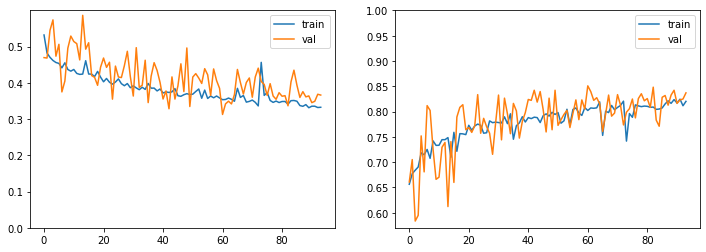

In [7]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6766 - accuracy: 0.5833 - precision: 0.7162 - recall: 0.5917 - f1: 0.6234 - specificity: 0.5678 - negative_predictive_value: 0.4352 - matthews_correlation_coefficient: 0.1599 - val_loss: 0.7081 - val_accuracy: 0.5516 - val_precision: 0.7615 - val_recall: 0.3945 - val_f1: 0.5097 - val_specificity: 0.7876 - val_negative_predictive_value: 0.4202 - val_matthews_correlation_coefficient: 0.2086

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.20859, saving model to ../models/autoencoders_requirements/looking_away_2020_03_15-16_19_37.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6721 - accuracy: 0.5902 - precision: 0.7250 - recall: 0.5774 - f1: 0.6216 - specificity: 0.6197 - negative_predictive_value: 0.4581 - matthews_correlation_coefficient: 0.1965 - val_loss: 0.6428 - val_accuracy: 0.6305 - val_precision

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6318 - accuracy: 0.6469 - precision: 0.7671 - recall: 0.6506 - f1: 0.6906 - specificity: 0.6377 - negative_predictive_value: 0.5060 - matthews_correlation_coefficient: 0.2797 - val_loss: 0.6533 - val_accuracy: 0.6253 - val_precision: 0.7783 - val_recall: 0.5977 - val_f1: 0.6712 - val_specificity: 0.6698 - val_negative_predictive_value: 0.4632 - val_matthews_correlation_coefficient: 0.2534

Epoch 00015: val_matthews_correlation_coefficient improved from 0.24997 to 0.25344, saving model to ../models/autoencoders_requirements/looking_away_2020_03_15-16_19_37.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6325 - accuracy: 0.6482 - precision: 0.7718 - recall: 0.6418 - f1: 0.6874 - specificity: 0.6516 - negative_predictive_value: 0.5103 - matthews_correlation_coefficient: 0.2901 - val_loss: 0.6335 - val_accuracy: 0.6435 - val_precision: 0.7842 - val_recall: 0.6298 - val_f1: 0.6944 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6011 - accuracy: 0.6744 - precision: 0.7958 - recall: 0.6759 - f1: 0.7202 - specificity: 0.6646 - negative_predictive_value: 0.5333 - matthews_correlation_coefficient: 0.3354 - val_loss: 0.5805 - val_accuracy: 0.6817 - val_precision: 0.7271 - val_recall: 0.8358 - val_f1: 0.7741 - val_specificity: 0.3921 - val_negative_predictive_value: 0.5484 - val_matthews_correlation_coefficient: 0.2491

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.29246
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5972 - accuracy: 0.6751 - precision: 0.7898 - recall: 0.6843 - f1: 0.7237 - specificity: 0.6581 - negative_predictive_value: 0.5410 - matthews_correlation_coefficient: 0.3375 - val_loss: 0.6143 - val_accuracy: 0.6470 - val_precision: 0.7605 - val_recall: 0.6847 - val_f1: 0.7168 - val_specificity: 0.5664 - val_negative_predictive_value: 0.4799 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.32791
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5768 - accuracy: 0.6935 - precision: 0.8057 - recall: 0.7014 - f1: 0.7414 - specificity: 0.6806 - negative_predictive_value: 0.5600 - matthews_correlation_coefficient: 0.3744 - val_loss: 0.5992 - val_accuracy: 0.6739 - val_precision: 0.7723 - val_recall: 0.7201 - val_f1: 0.7418 - val_specificity: 0.5823 - val_negative_predictive_value: 0.5179 - val_matthews_correlation_coefficient: 0.2957

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.32791
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5846 - accuracy: 0.6907 - precision: 0.8048 - recall: 0.6992 - f1: 0.7407 - specificity: 0.6795 - negative_predictive_value: 0.5511 - matthews_correlation_coefficient: 0.3666 - val_loss: 0.6184 - val_accuracy: 0.6522 - val_precision: 0.7841 - val_recall: 0.6572 - val_f1: 0.7098 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5731 - accuracy: 0.6859 - precision: 0.8038 - recall: 0.6762 - f1: 0.7252 - specificity: 0.7070 - negative_predictive_value: 0.5529 - matthews_correlation_coefficient: 0.3705 - val_loss: 0.6239 - val_accuracy: 0.6470 - val_precision: 0.8176 - val_recall: 0.6006 - val_f1: 0.6860 - val_specificity: 0.7252 - val_negative_predictive_value: 0.4838 - val_matthews_correlation_coefficient: 0.3123

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.33564
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5711 - accuracy: 0.7050 - precision: 0.8043 - recall: 0.7216 - f1: 0.7539 - specificity: 0.6708 - negative_predictive_value: 0.5732 - matthews_correlation_coefficient: 0.3856 - val_loss: 0.5827 - val_accuracy: 0.6834 - val_precision: 0.7959 - val_recall: 0.7035 - val_f1: 0.7422 - val_specificity: 0.6389 - val_negative_predictive_value: 0.5267 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.34339
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5532 - accuracy: 0.7091 - precision: 0.8222 - recall: 0.7052 - f1: 0.7513 - specificity: 0.7125 - negative_predictive_value: 0.5755 - matthews_correlation_coefficient: 0.4084 - val_loss: 0.6123 - val_accuracy: 0.6696 - val_precision: 0.7898 - val_recall: 0.6820 - val_f1: 0.7262 - val_specificity: 0.6492 - val_negative_predictive_value: 0.5158 - val_matthews_correlation_coefficient: 0.3174

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.34339
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5601 - accuracy: 0.6996 - precision: 0.8110 - recall: 0.7011 - f1: 0.7440 - specificity: 0.7100 - negative_predictive_value: 0.5723 - matthews_correlation_coefficient: 0.3956 - val_loss: 0.6322 - val_accuracy: 0.6531 - val_precision: 0.7614 - val_recall: 0.6915 - val_f1: 0.7208 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5600 - accuracy: 0.7030 - precision: 0.8172 - recall: 0.6992 - f1: 0.7453 - specificity: 0.7096 - negative_predictive_value: 0.5674 - matthews_correlation_coefficient: 0.3978 - val_loss: 0.5969 - val_accuracy: 0.6808 - val_precision: 0.7792 - val_recall: 0.7232 - val_f1: 0.7468 - val_specificity: 0.5967 - val_negative_predictive_value: 0.5247 - val_matthews_correlation_coefficient: 0.3112

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.35029
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5560 - accuracy: 0.7004 - precision: 0.8084 - recall: 0.7065 - f1: 0.7462 - specificity: 0.6973 - negative_predictive_value: 0.5631 - matthews_correlation_coefficient: 0.3880 - val_loss: 0.6052 - val_accuracy: 0.6600 - val_precision: 0.7985 - val_recall: 0.6487 - val_f1: 0.7118 - val_specificity: 0.6758 - val_negative_predictive_value: 0.4958 - val_matthews_correlation_coefficie

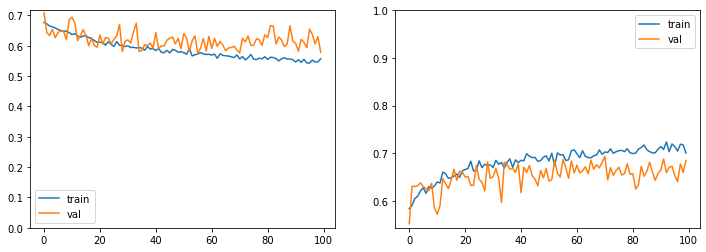

In [8]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

In [9]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

the requirement ink_marked_creased has only one label.


#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6487 - accuracy: 0.6137 - precision: 0.5661 - recall: 0.6587 - f1: 0.5607 - specificity: 0.5812 - negative_predictive_value: 0.7213 - matthews_correlation_coefficient: 0.2600 - val_loss: 0.6574 - val_accuracy: 0.5646 - val_precision: 0.4797 - val_recall: 0.0692 - val_f1: 0.1174 - val_specificity: 0.9250 - val_negative_predictive_value: 0.5502 - val_matthews_correlation_coefficient: 0.0473

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.04733, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_15-16_34_22.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6003 - accuracy: 0.6766 - precision: 0.5995 - recall: 0.7631 - f1: 0.6546 - specificity: 0.6072 - negative_predictive_value: 0.7862 - matthews_correlation_coefficient: 0.3855 - val_loss: 0.5786 - val_accuracy: 0.6930 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5091 - accuracy: 0.7273 - precision: 0.6621 - recall: 0.8166 - f1: 0.7202 - specificity: 0.6680 - negative_predictive_value: 0.8255 - matthews_correlation_coefficient: 0.4855 - val_loss: 0.5566 - val_accuracy: 0.6947 - val_precision: 0.6259 - val_recall: 0.6688 - val_f1: 0.6393 - val_specificity: 0.6816 - val_negative_predictive_value: 0.7181 - val_matthews_correlation_coefficient: 0.3740

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.45725
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5005 - accuracy: 0.7388 - precision: 0.6652 - recall: 0.8065 - f1: 0.7187 - specificity: 0.6825 - negative_predictive_value: 0.8210 - matthews_correlation_coefficient: 0.4940 - val_loss: 0.5340 - val_accuracy: 0.7173 - val_precision: 0.6282 - val_recall: 0.7747 - val_f1: 0.6873 - val_specificity: 0.6381 - val_negative_predictive_value: 0.7816 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4815 - accuracy: 0.7538 - precision: 0.6986 - recall: 0.8063 - f1: 0.7359 - specificity: 0.7228 - negative_predictive_value: 0.8262 - matthews_correlation_coefficient: 0.5263 - val_loss: 0.5202 - val_accuracy: 0.7199 - val_precision: 0.6614 - val_recall: 0.6682 - val_f1: 0.6571 - val_specificity: 0.7237 - val_negative_predictive_value: 0.7320 - val_matthews_correlation_coefficient: 0.4194

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.45725
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4748 - accuracy: 0.7638 - precision: 0.7024 - recall: 0.8001 - f1: 0.7384 - specificity: 0.7326 - negative_predictive_value: 0.8305 - matthews_correlation_coefficient: 0.5342 - val_loss: 0.5218 - val_accuracy: 0.7190 - val_precision: 0.7055 - val_recall: 0.5425 - val_f1: 0.6069 - val_specificity: 0.8181 - val_negative_predictive_value: 0.6910 - val_matthews_correlation_coefficie


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.48913
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4563 - accuracy: 0.7761 - precision: 0.7226 - recall: 0.8153 - f1: 0.7567 - specificity: 0.7422 - negative_predictive_value: 0.8338 - matthews_correlation_coefficient: 0.5583 - val_loss: 0.4990 - val_accuracy: 0.7467 - val_precision: 0.7213 - val_recall: 0.6296 - val_f1: 0.6642 - val_specificity: 0.8017 - val_negative_predictive_value: 0.7299 - val_matthews_correlation_coefficient: 0.4675

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.48913
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4649 - accuracy: 0.7714 - precision: 0.7141 - recall: 0.7991 - f1: 0.7431 - specificity: 0.7466 - negative_predictive_value: 0.8329 - matthews_correlation_coefficient: 0.5475 - val_loss: 0.5218 - val_accuracy: 0.7363 - val_precision: 0.6839 - val_recall: 0.6677 - val_f1: 0.6697 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.48913
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4516 - accuracy: 0.7751 - precision: 0.7364 - recall: 0.7846 - f1: 0.7458 - specificity: 0.7654 - negative_predictive_value: 0.8170 - matthews_correlation_coefficient: 0.5527 - val_loss: 0.5177 - val_accuracy: 0.7459 - val_precision: 0.6769 - val_recall: 0.7195 - val_f1: 0.6912 - val_specificity: 0.7295 - val_negative_predictive_value: 0.7690 - val_matthews_correlation_coefficient: 0.4743

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.48913
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4480 - accuracy: 0.7796 - precision: 0.7228 - recall: 0.8045 - f1: 0.7528 - specificity: 0.7513 - negative_predictive_value: 0.8319 - matthews_correlation_coefficient: 0.5618 - val_loss: 0.5093 - val_accuracy: 0.7363 - val_precision: 0.6966 - val_recall: 0.6347 - val_f1: 0.6568 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.50750
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4384 - accuracy: 0.7887 - precision: 0.7480 - recall: 0.8076 - f1: 0.7680 - specificity: 0.7789 - negative_predictive_value: 0.8381 - matthews_correlation_coefficient: 0.5858 - val_loss: 0.4992 - val_accuracy: 0.7337 - val_precision: 0.6884 - val_recall: 0.6500 - val_f1: 0.6618 - val_specificity: 0.7652 - val_negative_predictive_value: 0.7314 - val_matthews_correlation_coefficient: 0.4442

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.50750
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4369 - accuracy: 0.7900 - precision: 0.7351 - recall: 0.8051 - f1: 0.7600 - specificity: 0.7708 - negative_predictive_value: 0.8345 - matthews_correlation_coefficient: 0.5723 - val_loss: 0.4988 - val_accuracy: 0.7546 - val_precision: 0.7043 - val_recall: 0.6882 - val_f1: 0.6906 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4250 - accuracy: 0.8017 - precision: 0.7510 - recall: 0.8062 - f1: 0.7695 - specificity: 0.7916 - negative_predictive_value: 0.8482 - matthews_correlation_coefficient: 0.5998 - val_loss: 0.5091 - val_accuracy: 0.7502 - val_precision: 0.7180 - val_recall: 0.6389 - val_f1: 0.6691 - val_specificity: 0.8020 - val_negative_predictive_value: 0.7367 - val_matthews_correlation_coefficient: 0.4745

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.51489
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4145 - accuracy: 0.8052 - precision: 0.7620 - recall: 0.8134 - f1: 0.7789 - specificity: 0.7926 - negative_predictive_value: 0.8425 - matthews_correlation_coefficient: 0.6066 - val_loss: 0.4963 - val_accuracy: 0.7658 - val_precision: 0.7262 - val_recall: 0.6852 - val_f1: 0.6981 - val_specificity: 0.7958 - val_negative_predictive_value: 0.7590 - val_matthews_correlation_coefficie

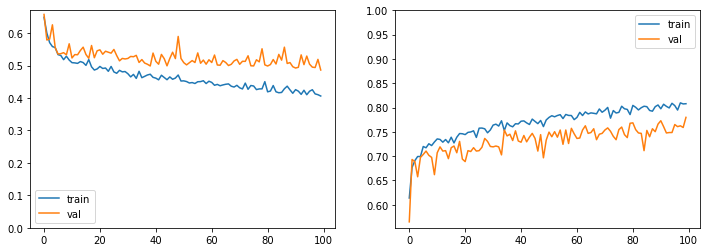

In [10]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5933 - accuracy: 0.7098 - precision: 0.9026 - recall: 0.7281 - f1: 0.7915 - specificity: 0.6471 - negative_predictive_value: 0.3920 - matthews_correlation_coefficient: 0.3267 - val_loss: 0.5287 - val_accuracy: 0.7736 - val_precision: 0.9162 - val_recall: 0.7534 - val_f1: 0.8236 - val_specificity: 0.7782 - val_negative_predictive_value: 0.4370 - val_matthews_correlation_coefficient: 0.4565

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.45649, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_15-16_49_07.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5299 - accuracy: 0.7503 - precision: 0.9354 - recall: 0.7529 - f1: 0.8263 - specificity: 0.7719 - negative_predictive_value: 0.4286 - matthews_correlation_coefficient: 0.4314 - val_loss: 0.4809 - val_accuracy: 0.8023 - val_precis

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4412 - accuracy: 0.8104 - precision: 0.9432 - recall: 0.8088 - f1: 0.8675 - specificity: 0.8189 - negative_predictive_value: 0.4976 - matthews_correlation_coefficient: 0.5222 - val_loss: 0.3873 - val_accuracy: 0.8352 - val_precision: 0.9245 - val_recall: 0.8240 - val_f1: 0.8689 - val_specificity: 0.7827 - val_negative_predictive_value: 0.5295 - val_matthews_correlation_coefficient: 0.5462

Epoch 00015: val_matthews_correlation_coefficient improved from 0.54522 to 0.54616, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_15-16_49_07.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4375 - accuracy: 0.8063 - precision: 0.9484 - recall: 0.8106 - f1: 0.8711 - specificity: 0.7957 - negative_predictive_value: 0.4874 - matthews_correlation_coefficient: 0.5075 - val_loss: 0.4456 - val_accuracy: 0.8083 - val_precision: 0.9311 - val_recall: 0.7838 - val_f1: 0.8483 - val_s


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.54616
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4143 - accuracy: 0.8226 - precision: 0.9538 - recall: 0.8252 - f1: 0.8814 - specificity: 0.8120 - negative_predictive_value: 0.5205 - matthews_correlation_coefficient: 0.5432 - val_loss: 0.6126 - val_accuracy: 0.7181 - val_precision: 0.9338 - val_recall: 0.6676 - val_f1: 0.7747 - val_specificity: 0.8530 - val_negative_predictive_value: 0.3793 - val_matthews_correlation_coefficient: 0.4278

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.54616
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4109 - accuracy: 0.8182 - precision: 0.9494 - recall: 0.8220 - f1: 0.8772 - specificity: 0.8116 - negative_predictive_value: 0.5070 - matthews_correlation_coefficient: 0.5349 - val_loss: 0.5150 - val_accuracy: 0.7511 - val_precision: 0.9383 - val_recall: 0.7065 - val_f1: 0.8029 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.58583
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3881 - accuracy: 0.8325 - precision: 0.9558 - recall: 0.8354 - f1: 0.8889 - specificity: 0.8259 - negative_predictive_value: 0.5326 - matthews_correlation_coefficient: 0.5626 - val_loss: 0.4842 - val_accuracy: 0.7875 - val_precision: 0.9378 - val_recall: 0.7528 - val_f1: 0.8318 - val_specificity: 0.8514 - val_negative_predictive_value: 0.4563 - val_matthews_correlation_coefficient: 0.5107

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.58583
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3964 - accuracy: 0.8228 - precision: 0.9565 - recall: 0.8217 - f1: 0.8804 - specificity: 0.8455 - negative_predictive_value: 0.5271 - matthews_correlation_coefficient: 0.5629 - val_loss: 0.5514 - val_accuracy: 0.7511 - val_precision: 0.9312 - val_recall: 0.7125 - val_f1: 0.8036 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.58583
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3765 - accuracy: 0.8395 - precision: 0.9549 - recall: 0.8435 - f1: 0.8920 - specificity: 0.8383 - negative_predictive_value: 0.5458 - matthews_correlation_coefficient: 0.5794 - val_loss: 0.5925 - val_accuracy: 0.7485 - val_precision: 0.9322 - val_recall: 0.7059 - val_f1: 0.8000 - val_specificity: 0.8442 - val_negative_predictive_value: 0.4054 - val_matthews_correlation_coefficient: 0.4549

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.58583
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3899 - accuracy: 0.8176 - precision: 0.9553 - recall: 0.8185 - f1: 0.8769 - specificity: 0.8252 - negative_predictive_value: 0.5148 - matthews_correlation_coefficient: 0.5443 - val_loss: 0.4999 - val_accuracy: 0.7806 - val_precision: 0.9425 - val_recall: 0.7410 - val_f1: 0.8267 - val_spe

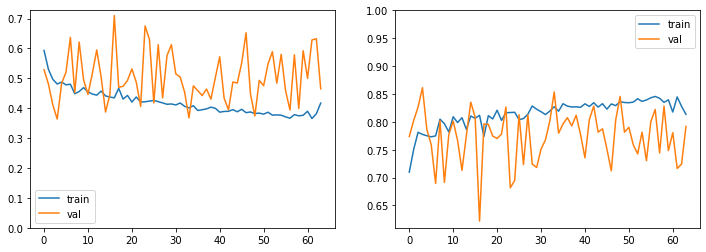

In [11]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5613 - accuracy: 0.6961 - precision: 0.9942 - recall: 0.6992 - f1: 0.8134 - specificity: 0.2241 - negative_predictive_value: 0.0296 - matthews_correlation_coefficient: 0.0533 - val_loss: 0.5021 - val_accuracy: 0.6340 - val_precision: 0.9938 - val_recall: 0.6436 - val_f1: 0.7768 - val_specificity: 0.2027 - val_negative_predictive_value: 0.0241 - val_matthews_correlation_coefficient: 0.0401

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.04013, saving model to ../models/autoencoders_requirements/washed_out_2020_03_15-16_58_44.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4495 - accuracy: 0.7074 - precision: 0.9973 - recall: 0.7068 - f1: 0.8180 - specificity: 0.2816 - negative_predictive_value: 0.0286 - matthews_correlation_coefficient: 0.0656 - val_loss: 0.1630 - val_accuracy: 0.9688 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2731 - accuracy: 0.8811 - precision: 0.9984 - recall: 0.8819 - f1: 0.9335 - specificity: 0.2828 - negative_predictive_value: 0.0901 - matthews_correlation_coefficient: 0.1395 - val_loss: 0.2207 - val_accuracy: 0.9263 - val_precision: 0.9920 - val_recall: 0.9351 - val_f1: 0.9619 - val_specificity: 0.1216 - val_negative_predictive_value: 0.0649 - val_matthews_correlation_coefficient: 0.0720

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.10324
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2409 - accuracy: 0.8957 - precision: 0.9982 - recall: 0.8970 - f1: 0.9412 - specificity: 0.3069 - negative_predictive_value: 0.1460 - matthews_correlation_coefficient: 0.1909 - val_loss: 0.1148 - val_accuracy: 0.9766 - val_precision: 0.9915 - val_recall: 0.9855 - val_f1: 0.9883 - val_specificity: 0.0946 - val_negative_predictive_value: 0.0856 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient improved from 0.12849 to 0.13378, saving model to ../models/autoencoders_requirements/washed_out_2020_03_15-16_58_44.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1724 - accuracy: 0.9297 - precision: 0.9988 - recall: 0.9303 - f1: 0.9616 - specificity: 0.3310 - negative_predictive_value: 0.1742 - matthews_correlation_coefficient: 0.2171 - val_loss: 0.1077 - val_accuracy: 0.9792 - val_precision: 0.9915 - val_recall: 0.9880 - val_f1: 0.9896 - val_specificity: 0.0946 - val_negative_predictive_value: 0.0856 - val_matthews_correlation_coefficient: 0.0846

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.13378
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1654 - accuracy: 0.9412 - precision: 0.9989 - recall: 0.9419 - f1: 0.9682 - specificity: 0.2805 - negative_predictive_value: 0.1410 - matthews_correlation_coefficient: 0.1868 - val_loss: 0.1365 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1569 - accuracy: 0.9399 - precision: 0.9986 - recall: 0.9409 - f1: 0.9678 - specificity: 0.3034 - negative_predictive_value: 0.1604 - matthews_correlation_coefficient: 0.2054 - val_loss: 0.1932 - val_accuracy: 0.9471 - val_precision: 0.9946 - val_recall: 0.9530 - val_f1: 0.9728 - val_specificity: 0.1892 - val_negative_predictive_value: 0.1414 - val_matthews_correlation_coefficient: 0.1491

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.17411
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1620 - accuracy: 0.9464 - precision: 0.9984 - recall: 0.9445 - f1: 0.9694 - specificity: 0.3207 - negative_predictive_value: 0.1951 - matthews_correlation_coefficient: 0.2338 - val_loss: 0.2582 - val_accuracy: 0.8846 - val_precision: 0.9953 - val_recall: 0.8905 - val_f1: 0.9388 - val_specificity: 0.2027 - val_negative_predictive_value: 0.0790 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1876 - accuracy: 0.9271 - precision: 0.9986 - recall: 0.9281 - f1: 0.9586 - specificity: 0.2977 - negative_predictive_value: 0.1521 - matthews_correlation_coefficient: 0.1958 - val_loss: 0.1378 - val_accuracy: 0.9731 - val_precision: 0.9948 - val_recall: 0.9786 - val_f1: 0.9864 - val_specificity: 0.1892 - val_negative_predictive_value: 0.1757 - val_matthews_correlation_coefficient: 0.1742

Epoch 00059: val_matthews_correlation_coefficient improved from 0.17411 to 0.17417, saving model to ../models/autoencoders_requirements/washed_out_2020_03_15-16_58_44.h5
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1498 - accuracy: 0.9434 - precision: 0.9987 - recall: 0.9445 - f1: 0.9701 - specificity: 0.2931 - negative_predictive_value: 0.1567 - matthews_correlation_coefficient: 0.2021 - val_loss: 0.1655 - val_accuracy: 0.9566 - val_precision: 0.9938 - val_recall: 0.9632 - val_f1: 0.9779 - val_speci


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.17417
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1301 - accuracy: 0.9666 - precision: 0.9989 - recall: 0.9675 - f1: 0.9826 - specificity: 0.2793 - negative_predictive_value: 0.1955 - matthews_correlation_coefficient: 0.2244 - val_loss: 0.1543 - val_accuracy: 0.9627 - val_precision: 0.9947 - val_recall: 0.9684 - val_f1: 0.9810 - val_specificity: 0.1757 - val_negative_predictive_value: 0.1459 - val_matthews_correlation_coefficient: 0.1494

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.17417
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1385 - accuracy: 0.9553 - precision: 0.9989 - recall: 0.9560 - f1: 0.9759 - specificity: 0.3103 - negative_predictive_value: 0.2082 - matthews_correlation_coefficient: 0.2350 - val_loss: 0.2352 - val_accuracy: 0.9081 - val_precision: 0.9953 - val_recall: 0.9137 - val_f1: 0.9519 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.17417
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1856 - accuracy: 0.9315 - precision: 0.9920 - recall: 0.9259 - f1: 0.9563 - specificity: 0.2724 - negative_predictive_value: 0.1669 - matthews_correlation_coefficient: 0.1981 - val_loss: 0.6972 - val_accuracy: 0.7355 - val_precision: 0.9958 - val_recall: 0.7430 - val_f1: 0.8469 - val_specificity: 0.2297 - val_negative_predictive_value: 0.0443 - val_matthews_correlation_coefficient: 0.0786
Restoring model weights from the end of the best epoch

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.17417
Epoch 00089: early stopping

   Final Accuracy:  97.31%
  Final Precision:  99.46%
     Final Recall:  97.80%
  Final F-measure:  98.63%
Final Specificity:  60.00%
        Final NPV:  26.47%
        Final MCC:  38.72%
[[   9    6]
 [  25 1113]]
              precision    recall  f1-score   support

           0 

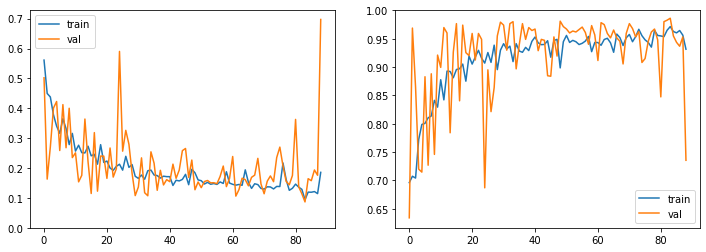

In [12]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6607 - accuracy: 0.6082 - precision: 0.9418 - recall: 0.6062 - f1: 0.7206 - specificity: 0.5688 - negative_predictive_value: 0.1184 - matthews_correlation_coefficient: 0.1312 - val_loss: 0.7112 - val_accuracy: 0.5516 - val_precision: 0.9725 - val_recall: 0.5446 - val_f1: 0.6927 - val_specificity: 0.6545 - val_negative_predictive_value: 0.1041 - val_matthews_correlation_coefficient: 0.1320

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.13204, saving model to ../models/autoencoders_requirements/pixelation_2020_03_15-17_11_57.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6359 - accuracy: 0.6145 - precision: 0.9679 - recall: 0.6107 - f1: 0.7363 - specificity: 0.6181 - negative_predictive_value: 0.1224 - matthews_correlation_coefficient: 0.1530 - val_loss: 0.4742 - val_accuracy: 0.7745 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5166 - accuracy: 0.7035 - precision: 0.9792 - recall: 0.6990 - f1: 0.8117 - specificity: 0.7047 - negative_predictive_value: 0.1616 - matthews_correlation_coefficient: 0.2406 - val_loss: 0.3715 - val_accuracy: 0.8118 - val_precision: 0.9643 - val_recall: 0.8340 - val_f1: 0.8927 - val_specificity: 0.5068 - val_negative_predictive_value: 0.1809 - val_matthews_correlation_coefficient: 0.2173

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.22502
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5095 - accuracy: 0.7163 - precision: 0.9783 - recall: 0.7106 - f1: 0.8197 - specificity: 0.6901 - negative_predictive_value: 0.1649 - matthews_correlation_coefficient: 0.2425 - val_loss: 0.3301 - val_accuracy: 0.8378 - val_precision: 0.9620 - val_recall: 0.8651 - val_f1: 0.9094 - val_specificity: 0.4437 - val_negative_predictive_value: 0.1922 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4817 - accuracy: 0.7230 - precision: 0.9816 - recall: 0.7191 - f1: 0.8269 - specificity: 0.7333 - negative_predictive_value: 0.1842 - matthews_correlation_coefficient: 0.2728 - val_loss: 0.3897 - val_accuracy: 0.7589 - val_precision: 0.9680 - val_recall: 0.7717 - val_f1: 0.8565 - val_specificity: 0.5685 - val_negative_predictive_value: 0.1579 - val_matthews_correlation_coefficient: 0.2039

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.22502
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5073 - accuracy: 0.6694 - precision: 0.9823 - recall: 0.6601 - f1: 0.7829 - specificity: 0.7794 - negative_predictive_value: 0.1598 - matthews_correlation_coefficient: 0.2517 - val_loss: 0.3468 - val_accuracy: 0.7823 - val_precision: 0.9688 - val_recall: 0.7974 - val_f1: 0.8727 - val_specificity: 0.5572 - val_negative_predictive_value: 0.1669 - val_matthews_correlation_coefficie

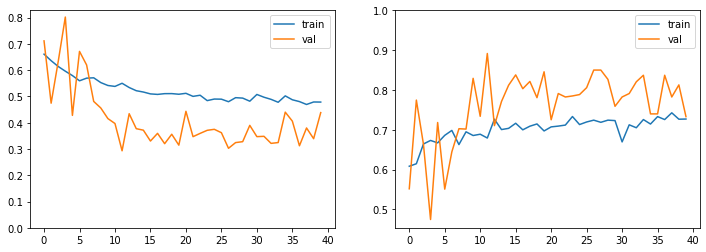

In [13]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5686 - accuracy: 0.7111 - precision: 0.9043 - recall: 0.6926 - f1: 0.7751 - specificity: 0.7721 - negative_predictive_value: 0.4481 - matthews_correlation_coefficient: 0.4100 - val_loss: 0.5379 - val_accuracy: 0.7251 - val_precision: 0.8941 - val_recall: 0.6686 - val_f1: 0.7628 - val_specificity: 0.8407 - val_negative_predictive_value: 0.4960 - val_matthews_correlation_coefficient: 0.4437

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.44371, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_15-17_17_55.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5559 - accuracy: 0.7117 - precision: 0.9151 - recall: 0.6756 - f1: 0.7724 - specificity: 0.8297 - negative_predictive_value: 0.4758 - matthews_correlation_coefficient: 0.4416 - val_loss: 0.5704 - val_accuracy: 0.7164 - val_preci

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5112 - accuracy: 0.7477 - precision: 0.9170 - recall: 0.7233 - f1: 0.8031 - specificity: 0.8223 - negative_predictive_value: 0.5136 - matthews_correlation_coefficient: 0.4839 - val_loss: 0.4948 - val_accuracy: 0.7554 - val_precision: 0.8906 - val_recall: 0.7169 - val_f1: 0.7924 - val_specificity: 0.8212 - val_negative_predictive_value: 0.5305 - val_matthews_correlation_coefficient: 0.4741

Epoch 00015: val_matthews_correlation_coefficient improved from 0.46126 to 0.47412, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_15-17_17_55.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5108 - accuracy: 0.7523 - precision: 0.9158 - recall: 0.7301 - f1: 0.8088 - specificity: 0.8069 - negative_predictive_value: 0.5143 - matthews_correlation_coefficient: 0.4800 - val_loss: 0.5174 - val_accuracy: 0.7381 - val_precision: 0.8936 - val_recall: 0.6886 - val_f1: 0.7756 - val


Epoch 00029: val_matthews_correlation_coefficient improved from 0.47587 to 0.47834, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_15-17_17_55.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4924 - accuracy: 0.7640 - precision: 0.9138 - recall: 0.7515 - f1: 0.8203 - specificity: 0.7960 - negative_predictive_value: 0.5317 - matthews_correlation_coefficient: 0.4932 - val_loss: 0.5609 - val_accuracy: 0.7303 - val_precision: 0.8992 - val_recall: 0.6704 - val_f1: 0.7663 - val_specificity: 0.8521 - val_negative_predictive_value: 0.5013 - val_matthews_correlation_coefficient: 0.4555

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.47834
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4885 - accuracy: 0.7646 - precision: 0.9170 - recall: 0.7539 - f1: 0.8237 - specificity: 0.8074 - negative_predictive_value: 0.5410 - matthews_correlation_coefficient: 0.5048 - val_loss: 0.56

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4809 - accuracy: 0.7605 - precision: 0.9137 - recall: 0.7381 - f1: 0.8116 - specificity: 0.8073 - negative_predictive_value: 0.5390 - matthews_correlation_coefficient: 0.4957 - val_loss: 0.5005 - val_accuracy: 0.7563 - val_precision: 0.8979 - val_recall: 0.7110 - val_f1: 0.7912 - val_specificity: 0.8382 - val_negative_predictive_value: 0.5327 - val_matthews_correlation_coefficient: 0.4843

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.49673
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4800 - accuracy: 0.7651 - precision: 0.9211 - recall: 0.7486 - f1: 0.8220 - specificity: 0.8043 - negative_predictive_value: 0.5288 - matthews_correlation_coefficient: 0.4967 - val_loss: 0.4389 - val_accuracy: 0.8066 - val_precision: 0.8344 - val_recall: 0.8608 - val_f1: 0.8458 - val_specificity: 0.6000 - val_negative_predictive_value: 0.6461 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4689 - accuracy: 0.7740 - precision: 0.9204 - recall: 0.7600 - f1: 0.8292 - specificity: 0.8166 - negative_predictive_value: 0.5496 - matthews_correlation_coefficient: 0.5185 - val_loss: 0.5067 - val_accuracy: 0.7554 - val_precision: 0.8912 - val_recall: 0.7161 - val_f1: 0.7923 - val_specificity: 0.8225 - val_negative_predictive_value: 0.5308 - val_matthews_correlation_coefficient: 0.4748

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.49688
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4615 - accuracy: 0.7770 - precision: 0.9216 - recall: 0.7633 - f1: 0.8302 - specificity: 0.8110 - negative_predictive_value: 0.5502 - matthews_correlation_coefficient: 0.5197 - val_loss: 0.5501 - val_accuracy: 0.7407 - val_precision: 0.9018 - val_recall: 0.6853 - val_f1: 0.7762 - val_specificity: 0.8568 - val_negative_predictive_value: 0.5163 - val_matthews_correlation_coefficie


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.51369
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4521 - accuracy: 0.7742 - precision: 0.9169 - recall: 0.7672 - f1: 0.8312 - specificity: 0.8068 - negative_predictive_value: 0.5544 - matthews_correlation_coefficient: 0.5174 - val_loss: 0.5270 - val_accuracy: 0.7424 - val_precision: 0.8983 - val_recall: 0.6902 - val_f1: 0.7782 - val_specificity: 0.8483 - val_negative_predictive_value: 0.5170 - val_matthews_correlation_coefficient: 0.4707

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.51369
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4550 - accuracy: 0.7738 - precision: 0.9194 - recall: 0.7636 - f1: 0.8289 - specificity: 0.8068 - negative_predictive_value: 0.5553 - matthews_correlation_coefficient: 0.5174 - val_loss: 0.5560 - val_accuracy: 0.7398 - val_precision: 0.8995 - val_recall: 0.6851 - val_f1: 0.7755 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4456 - accuracy: 0.7848 - precision: 0.9151 - recall: 0.7785 - f1: 0.8364 - specificity: 0.7985 - negative_predictive_value: 0.5596 - matthews_correlation_coefficient: 0.5229 - val_loss: 0.4895 - val_accuracy: 0.7858 - val_precision: 0.8939 - val_recall: 0.7573 - val_f1: 0.8177 - val_specificity: 0.8177 - val_negative_predictive_value: 0.5738 - val_matthews_correlation_coefficient: 0.5166

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.53025
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4449 - accuracy: 0.7803 - precision: 0.9208 - recall: 0.7701 - f1: 0.8346 - specificity: 0.8229 - negative_predictive_value: 0.5653 - matthews_correlation_coefficient: 0.5344 - val_loss: 0.5426 - val_accuracy: 0.7407 - val_precision: 0.9031 - val_recall: 0.6840 - val_f1: 0.7759 - val_specificity: 0.8593 - val_negative_predictive_value: 0.5147 - val_matthews_correlation_coefficie

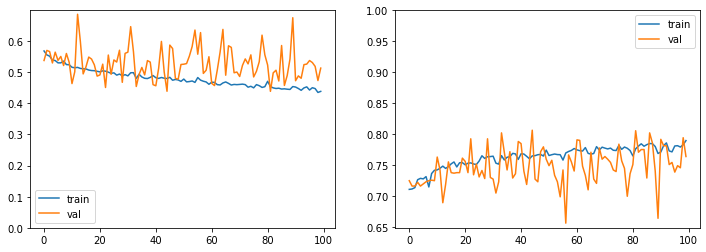

In [14]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6583 - accuracy: 0.5484 - precision: 0.8691 - recall: 0.4976 - f1: 0.6184 - specificity: 0.7227 - negative_predictive_value: 0.2921 - matthews_correlation_coefficient: 0.1906 - val_loss: 0.5877 - val_accuracy: 0.6479 - val_precision: 0.7940 - val_recall: 0.6836 - val_f1: 0.7314 - val_specificity: 0.4550 - val_negative_predictive_value: 0.3099 - val_matthews_correlation_coefficient: 0.1466

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.14655, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_15-17_33_05.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6608 - accuracy: 0.5501 - precision: 0.8694 - recall: 0.4972 - f1: 0.6149 - specificity: 0.7428 - negative_predictive_value: 0.3055 - matthews_correlation_coefficient: 0.2032 - val_loss: 0.6737 - val_accuracy: 0.5317 - val_precision

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6147 - accuracy: 0.6425 - precision: 0.8764 - recall: 0.6177 - f1: 0.7169 - specificity: 0.7078 - negative_predictive_value: 0.3597 - matthews_correlation_coefficient: 0.2821 - val_loss: 0.6027 - val_accuracy: 0.6626 - val_precision: 0.8438 - val_recall: 0.6459 - val_f1: 0.7297 - val_specificity: 0.6297 - val_negative_predictive_value: 0.3566 - val_matthews_correlation_coefficient: 0.2616

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.28334
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6182 - accuracy: 0.6427 - precision: 0.8905 - recall: 0.6194 - f1: 0.7194 - specificity: 0.7282 - negative_predictive_value: 0.3652 - matthews_correlation_coefficient: 0.2950 - val_loss: 0.6047 - val_accuracy: 0.6600 - val_precision: 0.8494 - val_recall: 0.6349 - val_f1: 0.7245 - val_specificity: 0.6563 - val_negative_predictive_value: 0.3605 - val_matthews_correlation_coefficie


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.31930
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5692 - accuracy: 0.6941 - precision: 0.8941 - recall: 0.6917 - f1: 0.7714 - specificity: 0.7103 - negative_predictive_value: 0.4063 - matthews_correlation_coefficient: 0.3440 - val_loss: 0.7332 - val_accuracy: 0.5915 - val_precision: 0.8551 - val_recall: 0.5277 - val_f1: 0.6474 - val_specificity: 0.7287 - val_negative_predictive_value: 0.3249 - val_matthews_correlation_coefficient: 0.2412

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.31930
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5696 - accuracy: 0.6926 - precision: 0.8972 - recall: 0.6817 - f1: 0.7678 - specificity: 0.7286 - negative_predictive_value: 0.4102 - matthews_correlation_coefficient: 0.3521 - val_loss: 0.5117 - val_accuracy: 0.7554 - val_precision: 0.8409 - val_recall: 0.8519 - val_f1: 0.8445 - val_spe


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.32783
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5526 - accuracy: 0.7121 - precision: 0.9007 - recall: 0.7084 - f1: 0.7881 - specificity: 0.7307 - negative_predictive_value: 0.4332 - matthews_correlation_coefficient: 0.3809 - val_loss: 0.6801 - val_accuracy: 0.6141 - val_precision: 0.8642 - val_recall: 0.5536 - val_f1: 0.6697 - val_specificity: 0.7392 - val_negative_predictive_value: 0.3394 - val_matthews_correlation_coefficient: 0.2704

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.32783
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5527 - accuracy: 0.7063 - precision: 0.8990 - recall: 0.6984 - f1: 0.7804 - specificity: 0.7133 - negative_predictive_value: 0.4168 - matthews_correlation_coefficient: 0.3597 - val_loss: 0.6223 - val_accuracy: 0.6444 - val_precision: 0.8748 - val_recall: 0.5882 - val_f1: 0.6983 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.34770
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5321 - accuracy: 0.7208 - precision: 0.8965 - recall: 0.7090 - f1: 0.7873 - specificity: 0.7352 - negative_predictive_value: 0.4383 - matthews_correlation_coefficient: 0.3827 - val_loss: 0.6223 - val_accuracy: 0.6592 - val_precision: 0.8684 - val_recall: 0.6138 - val_f1: 0.7159 - val_specificity: 0.7303 - val_negative_predictive_value: 0.3725 - val_matthews_correlation_coefficient: 0.3142

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.34770
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5431 - accuracy: 0.7100 - precision: 0.9027 - recall: 0.7036 - f1: 0.7833 - specificity: 0.7541 - negative_predictive_value: 0.4322 - matthews_correlation_coefficient: 0.3904 - val_loss: 0.7209 - val_accuracy: 0.6167 - val_precision: 0.8785 - val_recall: 0.5447 - val_f1: 0.6673 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.34770
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5278 - accuracy: 0.7262 - precision: 0.9073 - recall: 0.7186 - f1: 0.7953 - specificity: 0.7463 - negative_predictive_value: 0.4489 - matthews_correlation_coefficient: 0.4043 - val_loss: 0.6601 - val_accuracy: 0.6592 - val_precision: 0.8667 - val_recall: 0.6158 - val_f1: 0.7156 - val_specificity: 0.7214 - val_negative_predictive_value: 0.3728 - val_matthews_correlation_coefficient: 0.3104

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.34770
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5246 - accuracy: 0.7249 - precision: 0.9015 - recall: 0.7129 - f1: 0.7899 - specificity: 0.7439 - negative_predictive_value: 0.4436 - matthews_correlation_coefficient: 0.3972 - val_loss: 0.6098 - val_accuracy: 0.6600 - val_precision: 0.8689 - val_recall: 0.6133 - val_f1: 0.7152 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5188 - accuracy: 0.7226 - precision: 0.9104 - recall: 0.7110 - f1: 0.7924 - specificity: 0.7635 - negative_predictive_value: 0.4483 - matthews_correlation_coefficient: 0.4095 - val_loss: 0.6511 - val_accuracy: 0.6418 - val_precision: 0.8690 - val_recall: 0.5894 - val_f1: 0.6975 - val_specificity: 0.7362 - val_negative_predictive_value: 0.3593 - val_matthews_correlation_coefficient: 0.2990

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.35959
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5203 - accuracy: 0.7241 - precision: 0.9095 - recall: 0.7183 - f1: 0.7971 - specificity: 0.7458 - negative_predictive_value: 0.4385 - matthews_correlation_coefficient: 0.3985 - val_loss: 0.6282 - val_accuracy: 0.6635 - val_precision: 0.8809 - val_recall: 0.6092 - val_f1: 0.7149 - val_specificity: 0.7647 - val_negative_predictive_value: 0.3822 - val_matthews_correlation_coefficie

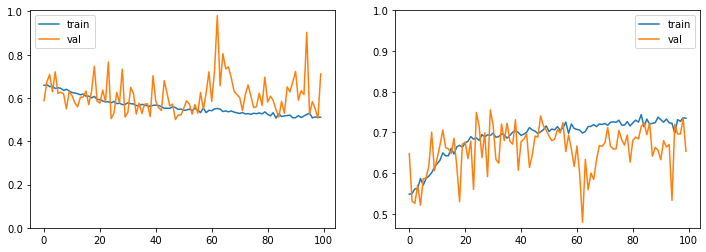

In [15]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5090 - accuracy: 0.7323 - precision: 0.7481 - recall: 0.6854 - f1: 0.6934 - specificity: 0.7827 - negative_predictive_value: 0.7255 - matthews_correlation_coefficient: 0.4787 - val_loss: 0.4237 - val_accuracy: 0.7797 - val_precision: 0.7492 - val_recall: 0.7991 - val_f1: 0.7696 - val_specificity: 0.7449 - val_negative_predictive_value: 0.7980 - val_matthews_correlation_coefficient: 0.5455

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.54550, saving model to ../models/autoencoders_requirements/varied_background_2020_03_15-17_48_00.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4407 - accuracy: 0.7666 - precision: 0.8049 - recall: 0.7614 - f1: 0.7645 - specificity: 0.7862 - negative_predictive_value: 0.7614 - matthews_correlation_coefficient: 0.5580 - val_loss: 0.4004 - val_accuracy: 0.7997 - val_prec


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.66024
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3626 - accuracy: 0.8195 - precision: 0.8528 - recall: 0.8080 - f1: 0.8207 - specificity: 0.8407 - negative_predictive_value: 0.8057 - matthews_correlation_coefficient: 0.6533 - val_loss: 0.3556 - val_accuracy: 0.8187 - val_precision: 0.7710 - val_recall: 0.8554 - val_f1: 0.8082 - val_specificity: 0.7606 - val_negative_predictive_value: 0.8585 - val_matthews_correlation_coefficient: 0.6225

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.66024
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3612 - accuracy: 0.8213 - precision: 0.8417 - recall: 0.8235 - f1: 0.8241 - specificity: 0.8303 - negative_predictive_value: 0.8135 - matthews_correlation_coefficient: 0.6542 - val_loss: 0.3395 - val_accuracy: 0.8239 - val_precision: 0.8526 - val_recall: 0.7405 - val_f1: 0.7895 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3482 - accuracy: 0.8278 - precision: 0.8449 - recall: 0.8144 - f1: 0.8219 - specificity: 0.8438 - negative_predictive_value: 0.8134 - matthews_correlation_coefficient: 0.6597 - val_loss: 0.3179 - val_accuracy: 0.8491 - val_precision: 0.8556 - val_recall: 0.7950 - val_f1: 0.8209 - val_specificity: 0.8867 - val_negative_predictive_value: 0.8264 - val_matthews_correlation_coefficient: 0.6817

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.68509
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3390 - accuracy: 0.8358 - precision: 0.8515 - recall: 0.8327 - f1: 0.8348 - specificity: 0.8403 - negative_predictive_value: 0.8192 - matthews_correlation_coefficient: 0.6732 - val_loss: 0.3704 - val_accuracy: 0.8109 - val_precision: 0.7400 - val_recall: 0.9042 - val_f1: 0.8106 - val_specificity: 0.6914 - val_negative_predictive_value: 0.9058 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3248 - accuracy: 0.8360 - precision: 0.8625 - recall: 0.8236 - f1: 0.8362 - specificity: 0.8586 - negative_predictive_value: 0.8173 - matthews_correlation_coefficient: 0.6808 - val_loss: 0.3603 - val_accuracy: 0.8135 - val_precision: 0.7596 - val_recall: 0.8612 - val_f1: 0.8044 - val_specificity: 0.7420 - val_negative_predictive_value: 0.8661 - val_matthews_correlation_coefficient: 0.6140

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.71426
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3275 - accuracy: 0.8375 - precision: 0.8554 - recall: 0.8376 - f1: 0.8399 - specificity: 0.8443 - negative_predictive_value: 0.8243 - matthews_correlation_coefficient: 0.6804 - val_loss: 0.3007 - val_accuracy: 0.8586 - val_precision: 0.8410 - val_recall: 0.8356 - val_f1: 0.8356 - val_specificity: 0.8617 - val_negative_predictive_value: 0.8579 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3064 - accuracy: 0.8562 - precision: 0.8714 - recall: 0.8562 - f1: 0.8593 - specificity: 0.8620 - negative_predictive_value: 0.8455 - matthews_correlation_coefficient: 0.7174 - val_loss: 0.2869 - val_accuracy: 0.8586 - val_precision: 0.8847 - val_recall: 0.7804 - val_f1: 0.8267 - val_specificity: 0.9179 - val_negative_predictive_value: 0.8213 - val_matthews_correlation_coefficient: 0.7019

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.73256
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3010 - accuracy: 0.8514 - precision: 0.8632 - recall: 0.8351 - f1: 0.8437 - specificity: 0.8632 - negative_predictive_value: 0.8414 - matthews_correlation_coefficient: 0.7030 - val_loss: 0.2824 - val_accuracy: 0.8673 - val_precision: 0.8698 - val_recall: 0.8188 - val_f1: 0.8402 - val_specificity: 0.8980 - val_negative_predictive_value: 0.8486 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3097 - accuracy: 0.8479 - precision: 0.8643 - recall: 0.8503 - f1: 0.8503 - specificity: 0.8561 - negative_predictive_value: 0.8423 - matthews_correlation_coefficient: 0.7063 - val_loss: 0.3246 - val_accuracy: 0.8586 - val_precision: 0.8103 - val_recall: 0.8834 - val_f1: 0.8430 - val_specificity: 0.8082 - val_negative_predictive_value: 0.8977 - val_matthews_correlation_coefficient: 0.6996

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.73256
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2942 - accuracy: 0.8531 - precision: 0.8746 - recall: 0.8384 - f1: 0.8509 - specificity: 0.8664 - negative_predictive_value: 0.8283 - matthews_correlation_coefficient: 0.7054 - val_loss: 0.4096 - val_accuracy: 0.7997 - val_precision: 0.7437 - val_recall: 0.8632 - val_f1: 0.7957 - val_specificity: 0.7096 - val_negative_predictive_value: 0.8628 - val_matthews_correlation_coefficie


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.73256
Epoch 00086: early stopping

   Final Accuracy:  87.68%
  Final Precision:  87.42%
     Final Recall:  89.17%
  Final F-measure:  88.28%
Final Specificity:  86.08%
        Final NPV:  87.99%
        Final MCC:  75.32%
[[476  77]
 [ 65 535]]
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       553
           1       0.87      0.89      0.88       600

    accuracy                           0.88      1153
   macro avg       0.88      0.88      0.88      1153
weighted avg       0.88      0.88      0.88      1153



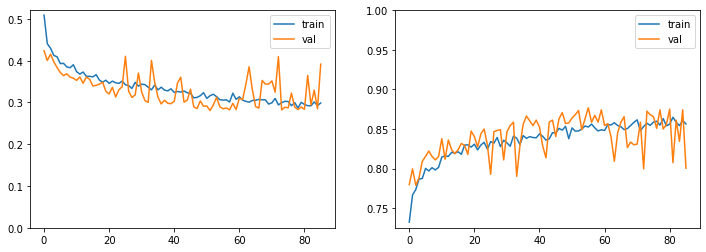

In [16]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5937 - accuracy: 0.7121 - precision: 0.8776 - recall: 0.7100 - f1: 0.7762 - specificity: 0.7218 - negative_predictive_value: 0.4558 - matthews_correlation_coefficient: 0.3844 - val_loss: 0.5658 - val_accuracy: 0.7025 - val_precision: 0.8713 - val_recall: 0.6555 - val_f1: 0.7437 - val_specificity: 0.7722 - val_negative_predictive_value: 0.4606 - val_matthews_correlation_coefficient: 0.4022

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.40221, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_15-18_00_48.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5804 - accuracy: 0.7148 - precision: 0.8974 - recall: 0.6908 - f1: 0.7771 - specificity: 0.7920 - negative_predictive_value: 0.4830 - matthews_correlation_coefficient: 0.4264 - val_loss: 0.5737 - val_accuracy: 0.7077 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5672 - accuracy: 0.7132 - precision: 0.8931 - recall: 0.6799 - f1: 0.7687 - specificity: 0.7884 - negative_predictive_value: 0.4753 - matthews_correlation_coefficient: 0.4136 - val_loss: 0.6321 - val_accuracy: 0.6956 - val_precision: 0.8887 - val_recall: 0.6298 - val_f1: 0.7323 - val_specificity: 0.8126 - val_negative_predictive_value: 0.4546 - val_matthews_correlation_coefficient: 0.4150

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.42008
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5666 - accuracy: 0.7165 - precision: 0.8988 - recall: 0.6889 - f1: 0.7763 - specificity: 0.7874 - negative_predictive_value: 0.4805 - matthews_correlation_coefficient: 0.4246 - val_loss: 0.5797 - val_accuracy: 0.7051 - val_precision: 0.8802 - val_recall: 0.6506 - val_f1: 0.7440 - val_specificity: 0.7908 - val_negative_predictive_value: 0.4628 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5543 - accuracy: 0.7195 - precision: 0.8992 - recall: 0.6949 - f1: 0.7802 - specificity: 0.7891 - negative_predictive_value: 0.4862 - matthews_correlation_coefficient: 0.4303 - val_loss: 0.5341 - val_accuracy: 0.7147 - val_precision: 0.8694 - val_recall: 0.6766 - val_f1: 0.7563 - val_specificity: 0.7577 - val_negative_predictive_value: 0.4739 - val_matthews_correlation_coefficient: 0.4114

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.42893
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5569 - accuracy: 0.7169 - precision: 0.8953 - recall: 0.6927 - f1: 0.7773 - specificity: 0.7821 - negative_predictive_value: 0.4809 - matthews_correlation_coefficient: 0.4223 - val_loss: 0.5640 - val_accuracy: 0.7086 - val_precision: 0.8802 - val_recall: 0.6570 - val_f1: 0.7479 - val_specificity: 0.7849 - val_negative_predictive_value: 0.4661 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5565 - accuracy: 0.7154 - precision: 0.8931 - recall: 0.6830 - f1: 0.7705 - specificity: 0.7925 - negative_predictive_value: 0.4819 - matthews_correlation_coefficient: 0.4274 - val_loss: 0.6096 - val_accuracy: 0.7008 - val_precision: 0.8864 - val_recall: 0.6390 - val_f1: 0.7382 - val_specificity: 0.8047 - val_negative_predictive_value: 0.4589 - val_matthews_correlation_coefficient: 0.4169

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.42893
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5570 - accuracy: 0.7061 - precision: 0.9030 - recall: 0.6768 - f1: 0.7674 - specificity: 0.7944 - negative_predictive_value: 0.4708 - matthews_correlation_coefficient: 0.4177 - val_loss: 0.5581 - val_accuracy: 0.7112 - val_precision: 0.8775 - val_recall: 0.6620 - val_f1: 0.7506 - val_specificity: 0.7790 - val_negative_predictive_value: 0.4681 - val_matthews_correlation_coefficie

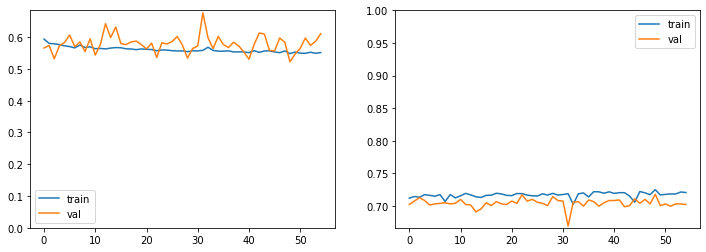

In [17]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6313 - accuracy: 0.6486 - precision: 0.6701 - recall: 0.6262 - f1: 0.6044 - specificity: 0.6590 - negative_predictive_value: 0.6722 - matthews_correlation_coefficient: 0.3113 - val_loss: 0.5976 - val_accuracy: 0.6331 - val_precision: 0.7072 - val_recall: 0.4072 - val_f1: 0.5069 - val_specificity: 0.8233 - val_negative_predictive_value: 0.5746 - val_matthews_correlation_coefficient: 0.2807

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28068, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_15-18_09_06.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5867 - accuracy: 0.6952 - precision: 0.6917 - recall: 0.7413 - f1: 0.6994 - specificity: 0.6531 - negative_predictive_value: 0.7239 - matthews_correlation_coefficient: 0.4059 - val_loss: 0.5662 - val_accuracy: 0.7034 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4751 - accuracy: 0.7607 - precision: 0.7564 - recall: 0.7848 - f1: 0.7607 - specificity: 0.7374 - negative_predictive_value: 0.7732 - matthews_correlation_coefficient: 0.5274 - val_loss: 0.4732 - val_accuracy: 0.7710 - val_precision: 0.7065 - val_recall: 0.8493 - val_f1: 0.7633 - val_specificity: 0.6567 - val_negative_predictive_value: 0.8202 - val_matthews_correlation_coefficient: 0.5427

Epoch 00014: val_matthews_correlation_coefficient improved from 0.53013 to 0.54267, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_15-18_09_06.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4712 - accuracy: 0.7573 - precision: 0.7560 - recall: 0.7840 - f1: 0.7581 - specificity: 0.7361 - negative_predictive_value: 0.7744 - matthews_correlation_coefficient: 0.5248 - val_loss: 0.4617 - val_accuracy: 0.7676 - val_precision: 0.7434 - val_recall: 0.7577 - val_f1: 0.74

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4411 - accuracy: 0.7813 - precision: 0.7763 - recall: 0.8010 - f1: 0.7799 - specificity: 0.7644 - negative_predictive_value: 0.7908 - matthews_correlation_coefficient: 0.5660 - val_loss: 0.4414 - val_accuracy: 0.7806 - val_precision: 0.7807 - val_recall: 0.7262 - val_f1: 0.7431 - val_specificity: 0.7997 - val_negative_predictive_value: 0.7436 - val_matthews_correlation_coefficient: 0.5517

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.56675
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4395 - accuracy: 0.7807 - precision: 0.7829 - recall: 0.7887 - f1: 0.7766 - specificity: 0.7741 - negative_predictive_value: 0.7819 - matthews_correlation_coefficient: 0.5652 - val_loss: 0.4808 - val_accuracy: 0.7572 - val_precision: 0.7063 - val_recall: 0.8024 - val_f1: 0.7441 - val_specificity: 0.6747 - val_negative_predictive_value: 0.7757 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4264 - accuracy: 0.7894 - precision: 0.7884 - recall: 0.7884 - f1: 0.7807 - specificity: 0.7874 - negative_predictive_value: 0.7963 - matthews_correlation_coefficient: 0.5818 - val_loss: 0.4447 - val_accuracy: 0.7806 - val_precision: 0.7571 - val_recall: 0.7729 - val_f1: 0.7564 - val_specificity: 0.7569 - val_negative_predictive_value: 0.7628 - val_matthews_correlation_coefficient: 0.5516

Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.57620
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4202 - accuracy: 0.7928 - precision: 0.7882 - recall: 0.7935 - f1: 0.7826 - specificity: 0.7871 - negative_predictive_value: 0.7977 - matthews_correlation_coefficient: 0.5845 - val_loss: 0.4442 - val_accuracy: 0.7762 - val_precision: 0.8108 - val_recall: 0.6759 - val_f1: 0.7291 - val_specificity: 0.8389 - val_negative_predictive_value: 0.7143 - val_matthews_correlation_coefficie


Epoch 00056: val_matthews_correlation_coefficient did not improve from 0.58376
Epoch 57/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4069 - accuracy: 0.8041 - precision: 0.8059 - recall: 0.8079 - f1: 0.7996 - specificity: 0.8016 - negative_predictive_value: 0.8030 - matthews_correlation_coefficient: 0.6107 - val_loss: 0.4444 - val_accuracy: 0.7910 - val_precision: 0.7547 - val_recall: 0.8081 - val_f1: 0.7720 - val_specificity: 0.7388 - val_negative_predictive_value: 0.7890 - val_matthews_correlation_coefficient: 0.5720

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.58376
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4127 - accuracy: 0.8072 - precision: 0.7998 - recall: 0.8123 - f1: 0.7998 - specificity: 0.7998 - negative_predictive_value: 0.8118 - matthews_correlation_coefficient: 0.6133 - val_loss: 0.4278 - val_accuracy: 0.7927 - val_precision: 0.7819 - val_recall: 0.7571 - val_f1: 0.7608 - val_spe


Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.59260
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4017 - accuracy: 0.8072 - precision: 0.8042 - recall: 0.8204 - f1: 0.8058 - specificity: 0.7908 - negative_predictive_value: 0.8097 - matthews_correlation_coefficient: 0.6123 - val_loss: 0.4415 - val_accuracy: 0.7953 - val_precision: 0.7730 - val_recall: 0.7797 - val_f1: 0.7693 - val_specificity: 0.7751 - val_negative_predictive_value: 0.7724 - val_matthews_correlation_coefficient: 0.5769

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.59260
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4026 - accuracy: 0.8059 - precision: 0.8061 - recall: 0.8152 - f1: 0.8031 - specificity: 0.7964 - negative_predictive_value: 0.8032 - matthews_correlation_coefficient: 0.6119 - val_loss: 0.4190 - val_accuracy: 0.7971 - val_precision: 0.7903 - val_recall: 0.7588 - val_f1: 0.7663 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3968 - accuracy: 0.8113 - precision: 0.8129 - recall: 0.8236 - f1: 0.8108 - specificity: 0.7981 - negative_predictive_value: 0.8114 - matthews_correlation_coefficient: 0.6226 - val_loss: 0.4212 - val_accuracy: 0.8101 - val_precision: 0.7709 - val_recall: 0.8252 - val_f1: 0.7893 - val_specificity: 0.7610 - val_negative_predictive_value: 0.8093 - val_matthews_correlation_coefficient: 0.6099

Epoch 00086: val_matthews_correlation_coefficient improved from 0.60536 to 0.60989, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_15-18_09_06.h5
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3938 - accuracy: 0.8143 - precision: 0.8145 - recall: 0.8262 - f1: 0.8145 - specificity: 0.8061 - negative_predictive_value: 0.8226 - matthews_correlation_coefficient: 0.6345 - val_loss: 0.4213 - val_accuracy: 0.7962 - val_precision: 0.8257 - val_recall: 0.7011 - val_f1: 0.75


Epoch 00100: val_matthews_correlation_coefficient did not improve from 0.61155

   Final Accuracy:  78.49%
  Final Precision:  80.71%
     Final Recall:  75.13%
  Final F-measure:  77.82%
Final Specificity:  81.88%
        Final NPV:  76.55%
        Final MCC:  57.13%
[[470 104]
 [144 435]]
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       574
           1       0.81      0.75      0.78       579

    accuracy                           0.78      1153
   macro avg       0.79      0.79      0.78      1153
weighted avg       0.79      0.78      0.78      1153



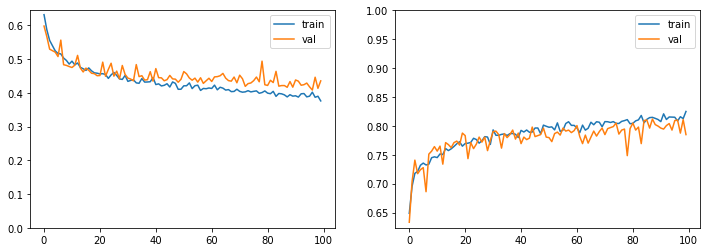

In [18]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6604 - accuracy: 0.5438 - precision: 0.8580 - recall: 0.4944 - f1: 0.5973 - specificity: 0.6912 - negative_predictive_value: 0.2858 - matthews_correlation_coefficient: 0.1703 - val_loss: 0.6178 - val_accuracy: 0.5993 - val_precision: 0.8312 - val_recall: 0.5547 - val_f1: 0.6613 - val_specificity: 0.6722 - val_negative_predictive_value: 0.3270 - val_matthews_correlation_coefficient: 0.2160

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21596, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_15-18_24_04.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6464 - accuracy: 0.5521 - precision: 0.8789 - recall: 0.4837 - f1: 0.6104 - specificity: 0.7848 - negative_predictive_value: 0.3259 - matthews_correlation_coefficient: 0.2315 - val_loss: 0.6816 - val_accuracy: 0.4727 - val_precision: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6081 - accuracy: 0.6360 - precision: 0.8943 - recall: 0.5968 - f1: 0.7056 - specificity: 0.7637 - negative_predictive_value: 0.3796 - matthews_correlation_coefficient: 0.3135 - val_loss: 0.5946 - val_accuracy: 0.6461 - val_precision: 0.8663 - val_recall: 0.5908 - val_f1: 0.6988 - val_specificity: 0.7459 - val_negative_predictive_value: 0.3700 - val_matthews_correlation_coefficient: 0.3082

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.32815
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5974 - accuracy: 0.6512 - precision: 0.8893 - recall: 0.6268 - f1: 0.7255 - specificity: 0.7423 - negative_predictive_value: 0.3897 - matthews_correlation_coefficient: 0.3170 - val_loss: 0.6824 - val_accuracy: 0.5481 - val_precision: 0.8867 - val_recall: 0.4366 - val_f1: 0.5799 - val_specificity: 0.8370 - val_negative_predictive_value: 0.3207 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5762 - accuracy: 0.6735 - precision: 0.8858 - recall: 0.6474 - f1: 0.7386 - specificity: 0.7466 - negative_predictive_value: 0.4101 - matthews_correlation_coefficient: 0.3406 - val_loss: 0.6364 - val_accuracy: 0.6167 - val_precision: 0.8797 - val_recall: 0.5387 - val_f1: 0.6646 - val_specificity: 0.7942 - val_negative_predictive_value: 0.3551 - val_matthews_correlation_coefficient: 0.3055

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.35809
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5716 - accuracy: 0.6705 - precision: 0.8969 - recall: 0.6465 - f1: 0.7452 - specificity: 0.7568 - negative_predictive_value: 0.4027 - matthews_correlation_coefficient: 0.3453 - val_loss: 0.5165 - val_accuracy: 0.7233 - val_precision: 0.8539 - val_recall: 0.7199 - val_f1: 0.7787 - val_specificity: 0.6568 - val_negative_predictive_value: 0.4349 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.37687
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5519 - accuracy: 0.6983 - precision: 0.8938 - recall: 0.6774 - f1: 0.7637 - specificity: 0.7616 - negative_predictive_value: 0.4323 - matthews_correlation_coefficient: 0.3772 - val_loss: 0.5323 - val_accuracy: 0.7095 - val_precision: 0.8669 - val_recall: 0.6862 - val_f1: 0.7632 - val_specificity: 0.7073 - val_negative_predictive_value: 0.4260 - val_matthews_correlation_coefficient: 0.3655

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.37687
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5443 - accuracy: 0.7013 - precision: 0.9006 - recall: 0.6856 - f1: 0.7727 - specificity: 0.7407 - negative_predictive_value: 0.4278 - matthews_correlation_coefficient: 0.3735 - val_loss: 0.5234 - val_accuracy: 0.7121 - val_precision: 0.8368 - val_recall: 0.7826 - val_f1: 0.8064 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.37857
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5464 - accuracy: 0.7054 - precision: 0.8872 - recall: 0.6992 - f1: 0.7737 - specificity: 0.7152 - negative_predictive_value: 0.4402 - matthews_correlation_coefficient: 0.3648 - val_loss: 0.8186 - val_accuracy: 0.5507 - val_precision: 0.8733 - val_recall: 0.4486 - val_f1: 0.5877 - val_specificity: 0.8110 - val_negative_predictive_value: 0.3184 - val_matthews_correlation_coefficient: 0.2489

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.37857
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5513 - accuracy: 0.6889 - precision: 0.8949 - recall: 0.6656 - f1: 0.7532 - specificity: 0.7580 - negative_predictive_value: 0.4293 - matthews_correlation_coefficient: 0.3748 - val_loss: 0.6019 - val_accuracy: 0.6453 - val_precision: 0.8819 - val_recall: 0.5783 - val_f1: 0.6956 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.39771
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5151 - accuracy: 0.7297 - precision: 0.9027 - recall: 0.7229 - f1: 0.7971 - specificity: 0.7378 - negative_predictive_value: 0.4615 - matthews_correlation_coefficient: 0.4087 - val_loss: 0.5815 - val_accuracy: 0.6574 - val_precision: 0.8807 - val_recall: 0.5999 - val_f1: 0.7097 - val_specificity: 0.7656 - val_negative_predictive_value: 0.3848 - val_matthews_correlation_coefficient: 0.3376

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.39771
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5210 - accuracy: 0.7252 - precision: 0.9059 - recall: 0.7171 - f1: 0.7925 - specificity: 0.7409 - negative_predictive_value: 0.4588 - matthews_correlation_coefficient: 0.4070 - val_loss: 0.5373 - val_accuracy: 0.7016 - val_precision: 0.8722 - val_recall: 0.6692 - val_f1: 0.7544 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.39771
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5246 - accuracy: 0.7273 - precision: 0.9032 - recall: 0.7220 - f1: 0.7951 - specificity: 0.7510 - negative_predictive_value: 0.4688 - matthews_correlation_coefficient: 0.4170 - val_loss: 0.5912 - val_accuracy: 0.6626 - val_precision: 0.8930 - val_recall: 0.5973 - val_f1: 0.7117 - val_specificity: 0.8025 - val_negative_predictive_value: 0.3926 - val_matthews_correlation_coefficient: 0.3639

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.39771
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5004 - accuracy: 0.7393 - precision: 0.9093 - recall: 0.7316 - f1: 0.8059 - specificity: 0.7508 - negative_predictive_value: 0.4686 - matthews_correlation_coefficient: 0.4259 - val_loss: 0.6217 - val_accuracy: 0.6461 - val_precision: 0.8844 - val_recall: 0.5805 - val_f1: 0.6973 - val_spe

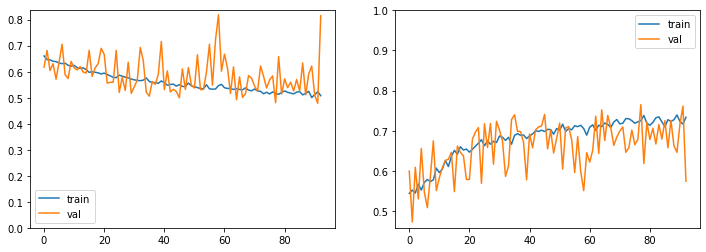

In [19]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4394 - accuracy: 0.7807 - precision: 0.8899 - recall: 0.7761 - f1: 0.8196 - specificity: 0.7924 - negative_predictive_value: 0.6427 - matthews_correlation_coefficient: 0.5514 - val_loss: 0.3848 - val_accuracy: 0.7944 - val_precision: 0.9201 - val_recall: 0.7612 - val_f1: 0.8277 - val_specificity: 0.8416 - val_negative_predictive_value: 0.6351 - val_matthews_correlation_coefficient: 0.5772

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.57724, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_15-18_37_54.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3697 - accuracy: 0.8100 - precision: 0.9295 - recall: 0.7726 - f1: 0.8393 - specificity: 0.8855 - negative_predictive_value: 0.6698 - matthews_correlation_coefficient: 0.6270 - val_loss: 0.3917 - val_accuracy: 0.7884 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.69064
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2970 - accuracy: 0.8544 - precision: 0.9469 - recall: 0.8277 - f1: 0.8795 - specificity: 0.9110 - negative_predictive_value: 0.7381 - matthews_correlation_coefficient: 0.7104 - val_loss: 0.3450 - val_accuracy: 0.8248 - val_precision: 0.9588 - val_recall: 0.7702 - val_f1: 0.8488 - val_specificity: 0.9116 - val_negative_predictive_value: 0.6646 - val_matthews_correlation_coefficient: 0.6507

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.69064
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3052 - accuracy: 0.8488 - precision: 0.9518 - recall: 0.8137 - f1: 0.8730 - specificity: 0.9148 - negative_predictive_value: 0.7196 - matthews_correlation_coefficient: 0.6982 - val_loss: 0.3027 - val_accuracy: 0.8638 - val_precision: 0.9018 - val_recall: 0.8946 - val_f1: 0.8961 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2753 - accuracy: 0.8701 - precision: 0.9494 - recall: 0.8502 - f1: 0.8938 - specificity: 0.9058 - negative_predictive_value: 0.7554 - matthews_correlation_coefficient: 0.7279 - val_loss: 0.2877 - val_accuracy: 0.8751 - val_precision: 0.9252 - val_recall: 0.8877 - val_f1: 0.9034 - val_specificity: 0.8279 - val_negative_predictive_value: 0.7725 - val_matthews_correlation_coefficient: 0.7059

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.70792
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2714 - accuracy: 0.8770 - precision: 0.9444 - recall: 0.8532 - f1: 0.8929 - specificity: 0.9115 - negative_predictive_value: 0.7724 - matthews_correlation_coefficient: 0.7463 - val_loss: 0.3840 - val_accuracy: 0.7971 - val_precision: 0.9650 - val_recall: 0.7231 - val_f1: 0.8213 - val_specificity: 0.9233 - val_negative_predictive_value: 0.6235 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.72905
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2596 - accuracy: 0.8826 - precision: 0.9528 - recall: 0.8644 - f1: 0.9035 - specificity: 0.9161 - negative_predictive_value: 0.7772 - matthews_correlation_coefficient: 0.7537 - val_loss: 0.2639 - val_accuracy: 0.8846 - val_precision: 0.9420 - val_recall: 0.8846 - val_f1: 0.9102 - val_specificity: 0.8615 - val_negative_predictive_value: 0.7705 - val_matthews_correlation_coefficient: 0.7284

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.72905
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2618 - accuracy: 0.8824 - precision: 0.9475 - recall: 0.8716 - f1: 0.9047 - specificity: 0.9118 - negative_predictive_value: 0.7935 - matthews_correlation_coefficient: 0.7607 - val_loss: 0.2988 - val_accuracy: 0.8474 - val_precision: 0.9143 - val_recall: 0.8537 - val_f1: 0.8801 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.74978
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2446 - accuracy: 0.8907 - precision: 0.9487 - recall: 0.8834 - f1: 0.9119 - specificity: 0.9058 - negative_predictive_value: 0.8019 - matthews_correlation_coefficient: 0.7684 - val_loss: 0.2564 - val_accuracy: 0.8846 - val_precision: 0.8980 - val_recall: 0.9356 - val_f1: 0.9147 - val_specificity: 0.7623 - val_negative_predictive_value: 0.8356 - val_matthews_correlation_coefficient: 0.7148

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.74978
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2368 - accuracy: 0.9020 - precision: 0.9560 - recall: 0.8921 - f1: 0.9203 - specificity: 0.9243 - negative_predictive_value: 0.8251 - matthews_correlation_coefficient: 0.7976 - val_loss: 0.2858 - val_accuracy: 0.8699 - val_precision: 0.9659 - val_recall: 0.8369 - val_f1: 0.8940 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2193 - accuracy: 0.9087 - precision: 0.9582 - recall: 0.9015 - f1: 0.9273 - specificity: 0.9263 - negative_predictive_value: 0.8308 - matthews_correlation_coefficient: 0.8074 - val_loss: 0.2677 - val_accuracy: 0.8838 - val_precision: 0.9585 - val_recall: 0.8658 - val_f1: 0.9081 - val_specificity: 0.8911 - val_negative_predictive_value: 0.7504 - val_matthews_correlation_coefficient: 0.7320

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.76858
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2257 - accuracy: 0.9059 - precision: 0.9552 - recall: 0.8977 - f1: 0.9224 - specificity: 0.9200 - negative_predictive_value: 0.8223 - matthews_correlation_coefficient: 0.7980 - val_loss: 0.2640 - val_accuracy: 0.8812 - val_precision: 0.9585 - val_recall: 0.8621 - val_f1: 0.9052 - val_specificity: 0.8983 - val_negative_predictive_value: 0.7491 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2180 - accuracy: 0.9100 - precision: 0.9551 - recall: 0.9058 - f1: 0.9275 - specificity: 0.9140 - negative_predictive_value: 0.8343 - matthews_correlation_coefficient: 0.8036 - val_loss: 0.3391 - val_accuracy: 0.8569 - val_precision: 0.9689 - val_recall: 0.8131 - val_f1: 0.8817 - val_specificity: 0.9230 - val_negative_predictive_value: 0.7017 - val_matthews_correlation_coefficient: 0.7014 - precision: 0.9548 - recall: 0.9019 - f1: 0.9250 - specificity: 0.9189 - negative_predictive_value: 0.8349 - matthews_correlation_c

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.76858
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2157 - accuracy: 0.9085 - precision: 0.9559 - recall: 0.8989 - f1: 0.9242 - specificity: 0.9228 - negative_predictive_value: 0.8233 - matthews_correlation_coefficient: 0.8013 - val_loss: 0.3266 - val_accuracy: 0.8569 - val_precision: 0.9706 - val_r

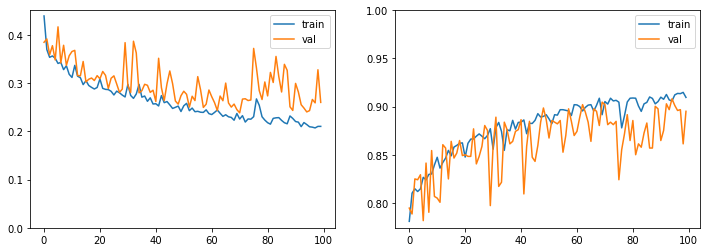

In [20]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6009 - accuracy: 0.6531 - precision: 0.6995 - recall: 0.6289 - f1: 0.6436 - specificity: 0.6820 - negative_predictive_value: 0.6280 - matthews_correlation_coefficient: 0.3228 - val_loss: 0.5847 - val_accuracy: 0.6401 - val_precision: 0.8105 - val_recall: 0.3993 - val_f1: 0.5247 - val_specificity: 0.8854 - val_negative_predictive_value: 0.5516 - val_matthews_correlation_coefficient: 0.3460

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.34605, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_15-18_52_45.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5696 - accuracy: 0.6794 - precision: 0.7433 - recall: 0.6559 - f1: 0.6767 - specificity: 0.7153 - negative_predictive_value: 0.6516 - matthews_correlation_coefficient: 0.3813 - val_loss: 0.5188 - val_accuracy: 0.7216 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.54644
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5002 - accuracy: 0.7538 - precision: 0.7869 - recall: 0.7624 - f1: 0.7670 - specificity: 0.7473 - negative_predictive_value: 0.7285 - matthews_correlation_coefficient: 0.5123 - val_loss: 0.4597 - val_accuracy: 0.7806 - val_precision: 0.8222 - val_recall: 0.7793 - val_f1: 0.7920 - val_specificity: 0.7661 - val_negative_predictive_value: 0.7291 - val_matthews_correlation_coefficient: 0.5480

Epoch 00015: val_matthews_correlation_coefficient improved from 0.54644 to 0.54803, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_15-18_52_45.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4984 - accuracy: 0.7475 - precision: 0.7772 - recall: 0.7476 - f1: 0.7530 - specificity: 0.7428 - negative_predictive_value: 0.7176 - matthews_correlation_coefficient: 0.4939 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4585 - accuracy: 0.7781 - precision: 0.8100 - recall: 0.7873 - f1: 0.7884 - specificity: 0.7703 - negative_predictive_value: 0.7570 - matthews_correlation_coefficient: 0.5612 - val_loss: 0.4410 - val_accuracy: 0.7918 - val_precision: 0.8328 - val_recall: 0.7219 - val_f1: 0.7661 - val_specificity: 0.8265 - val_negative_predictive_value: 0.7202 - val_matthews_correlation_coefficient: 0.5773

Epoch 00029: val_matthews_correlation_coefficient improved from 0.57073 to 0.57725, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_15-18_52_45.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4557 - accuracy: 0.7785 - precision: 0.8083 - recall: 0.7898 - f1: 0.7900 - specificity: 0.7660 - negative_predictive_value: 0.7547 - matthews_correlation_coefficient: 0.5607 - val_loss: 0.4463 - val_accuracy: 0.7901 - val_precision: 0.8274 - val_recall: 0.7868 - val_f1: 0.8018 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4327 - accuracy: 0.7915 - precision: 0.8251 - recall: 0.7934 - f1: 0.8019 - specificity: 0.7887 - negative_predictive_value: 0.7605 - matthews_correlation_coefficient: 0.5835 - val_loss: 0.4362 - val_accuracy: 0.7971 - val_precision: 0.7491 - val_recall: 0.8717 - val_f1: 0.8020 - val_specificity: 0.6652 - val_negative_predictive_value: 0.8260 - val_matthews_correlation_coefficient: 0.5820

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.59765
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4345 - accuracy: 0.7957 - precision: 0.8177 - recall: 0.8078 - f1: 0.8067 - specificity: 0.7844 - negative_predictive_value: 0.7655 - matthews_correlation_coefficient: 0.5891 - val_loss: 0.4576 - val_accuracy: 0.7901 - val_precision: 0.7430 - val_recall: 0.8654 - val_f1: 0.7966 - val_specificity: 0.6552 - val_negative_predictive_value: 0.8129 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient improved from 0.60792 to 0.60993, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_15-18_52_45.h5
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4232 - accuracy: 0.8035 - precision: 0.8378 - recall: 0.7970 - f1: 0.8091 - specificity: 0.8080 - negative_predictive_value: 0.7708 - matthews_correlation_coefficient: 0.6082 - val_loss: 0.4207 - val_accuracy: 0.8135 - val_precision: 0.8115 - val_recall: 0.8030 - val_f1: 0.8035 - val_specificity: 0.7782 - val_negative_predictive_value: 0.7680 - val_matthews_correlation_coefficient: 0.6072

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.60993
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4143 - accuracy: 0.8091 - precision: 0.8308 - recall: 0.8033 - f1: 0.8117 - specificity: 0.8119 - negative_predictive_value: 0.7794 - matthews_correlation_coefficient: 0.6142 - val_loss: 0


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.60993
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4189 - accuracy: 0.7996 - precision: 0.8335 - recall: 0.7856 - f1: 0.8015 - specificity: 0.8122 - negative_predictive_value: 0.7627 - matthews_correlation_coefficient: 0.6035 - val_loss: 0.4187 - val_accuracy: 0.8066 - val_precision: 0.7795 - val_recall: 0.8338 - val_f1: 0.8026 - val_specificity: 0.7254 - val_negative_predictive_value: 0.7928 - val_matthews_correlation_coefficient: 0.5925

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.60993
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4165 - accuracy: 0.7996 - precision: 0.8297 - recall: 0.8008 - f1: 0.8090 - specificity: 0.8075 - negative_predictive_value: 0.7741 - matthews_correlation_coefficient: 0.6058 - val_loss: 0.4362 - val_accuracy: 0.7979 - val_precision: 0.7980 - val_recall: 0.8566 - val_f1: 0.8220 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.62604
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4038 - accuracy: 0.8033 - precision: 0.8290 - recall: 0.7903 - f1: 0.8041 - specificity: 0.8086 - negative_predictive_value: 0.7661 - matthews_correlation_coefficient: 0.6037 - val_loss: 0.4294 - val_accuracy: 0.8040 - val_precision: 0.7743 - val_recall: 0.8395 - val_f1: 0.8019 - val_specificity: 0.7174 - val_negative_predictive_value: 0.7967 - val_matthews_correlation_coefficient: 0.5905

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.62604
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3986 - accuracy: 0.8028 - precision: 0.8262 - recall: 0.7953 - f1: 0.8055 - specificity: 0.7995 - negative_predictive_value: 0.7659 - matthews_correlation_coefficient: 0.5932 - val_loss: 0.4405 - val_accuracy: 0.7971 - val_precision: 0.7523 - val_recall: 0.8625 - val_f1: 0.8000 - val_spe

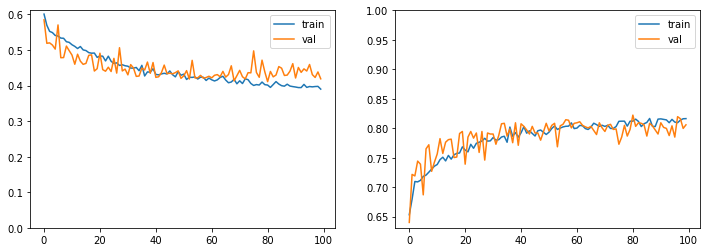

In [21]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5843 - accuracy: 0.5241 - precision: 0.9661 - recall: 0.4863 - f1: 0.6379 - specificity: 0.8372 - negative_predictive_value: 0.1806 - matthews_correlation_coefficient: 0.2149 - val_loss: 0.7257 - val_accuracy: 0.4623 - val_precision: 0.9548 - val_recall: 0.3915 - val_f1: 0.5497 - val_specificity: 0.8493 - val_negative_predictive_value: 0.1585 - val_matthews_correlation_coefficient: 0.1955

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.19548, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_15-19_07_35.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5736 - accuracy: 0.5423 - precision: 0.9668 - recall: 0.5083 - f1: 0.6542 - specificity: 0.8180 - negative_predictive_value: 0.1779 - matthews_correlation_coefficient: 0.2157 - val_loss: 0.5516 - val_accuracy: 0.5594 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4719 - accuracy: 0.7117 - precision: 0.9746 - recall: 0.6962 - f1: 0.8046 - specificity: 0.8009 - negative_predictive_value: 0.2767 - matthews_correlation_coefficient: 0.3517 - val_loss: 0.6381 - val_accuracy: 0.5880 - val_precision: 0.9564 - val_recall: 0.5293 - val_f1: 0.6773 - val_specificity: 0.8866 - val_negative_predictive_value: 0.2202 - val_matthews_correlation_coefficient: 0.2682

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.33392
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4622 - accuracy: 0.7243 - precision: 0.9655 - recall: 0.7069 - f1: 0.8085 - specificity: 0.8192 - negative_predictive_value: 0.2799 - matthews_correlation_coefficient: 0.3565 - val_loss: 0.5366 - val_accuracy: 0.6739 - val_precision: 0.9456 - val_recall: 0.6343 - val_f1: 0.7556 - val_specificity: 0.7938 - val_negative_predictive_value: 0.2219 - val_matthews_correlation_coefficie


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.36641
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3932 - accuracy: 0.7805 - precision: 0.9771 - recall: 0.7742 - f1: 0.8588 - specificity: 0.8210 - negative_predictive_value: 0.3362 - matthews_correlation_coefficient: 0.4248 - val_loss: 0.4302 - val_accuracy: 0.7528 - val_precision: 0.9483 - val_recall: 0.7209 - val_f1: 0.8169 - val_specificity: 0.8006 - val_negative_predictive_value: 0.3027 - val_matthews_correlation_coefficient: 0.3568

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.36641
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3943 - accuracy: 0.7729 - precision: 0.9771 - recall: 0.7655 - f1: 0.8525 - specificity: 0.8573 - negative_predictive_value: 0.3437 - matthews_correlation_coefficient: 0.4384 - val_loss: 0.3484 - val_accuracy: 0.8170 - val_precision: 0.9348 - val_recall: 0.8059 - val_f1: 0.8635 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3581 - accuracy: 0.8069 - precision: 0.9811 - recall: 0.7997 - f1: 0.8758 - specificity: 0.8483 - negative_predictive_value: 0.3931 - matthews_correlation_coefficient: 0.4813 - val_loss: 0.5577 - val_accuracy: 0.6964 - val_precision: 0.9597 - val_recall: 0.6499 - val_f1: 0.7717 - val_specificity: 0.8837 - val_negative_predictive_value: 0.2743 - val_matthews_correlation_coefficient: 0.3479

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.38470
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3879 - accuracy: 0.7892 - precision: 0.9767 - recall: 0.7851 - f1: 0.8634 - specificity: 0.8094 - negative_predictive_value: 0.3609 - matthews_correlation_coefficient: 0.4400 - val_loss: 0.5434 - val_accuracy: 0.6938 - val_precision: 0.9566 - val_recall: 0.6487 - val_f1: 0.7699 - val_specificity: 0.8528 - val_negative_predictive_value: 0.2715 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3553 - accuracy: 0.8102 - precision: 0.9789 - recall: 0.8047 - f1: 0.8777 - specificity: 0.8699 - negative_predictive_value: 0.3945 - matthews_correlation_coefficient: 0.4924 - val_loss: 0.5124 - val_accuracy: 0.7086 - val_precision: 0.9624 - val_recall: 0.6617 - val_f1: 0.7820 - val_specificity: 0.8765 - val_negative_predictive_value: 0.2831 - val_matthews_correlation_coefficient: 0.3598

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.39815
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4059 - accuracy: 0.7679 - precision: 0.9738 - recall: 0.7513 - f1: 0.8395 - specificity: 0.8113 - negative_predictive_value: 0.3264 - matthews_correlation_coefficient: 0.4057 - val_loss: 0.6131 - val_accuracy: 0.6652 - val_precision: 0.9673 - val_recall: 0.6095 - val_f1: 0.7439 - val_specificity: 0.9412 - val_negative_predictive_value: 0.2629 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3288 - accuracy: 0.8289 - precision: 0.9824 - recall: 0.8238 - f1: 0.8915 - specificity: 0.8541 - negative_predictive_value: 0.4281 - matthews_correlation_coefficient: 0.5171 - val_loss: 0.5742 - val_accuracy: 0.6982 - val_precision: 0.9636 - val_recall: 0.6494 - val_f1: 0.7729 - val_specificity: 0.9020 - val_negative_predictive_value: 0.2798 - val_matthews_correlation_coefficient: 0.3612

Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.41784
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3353 - accuracy: 0.8282 - precision: 0.9824 - recall: 0.8206 - f1: 0.8900 - specificity: 0.8227 - negative_predictive_value: 0.4102 - matthews_correlation_coefficient: 0.4959 - val_loss: 0.5480 - val_accuracy: 0.7121 - val_precision: 0.9638 - val_recall: 0.6642 - val_f1: 0.7840 - val_specificity: 0.9035 - val_negative_predictive_value: 0.2866 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3219 - accuracy: 0.8267 - precision: 0.9846 - recall: 0.8203 - f1: 0.8913 - specificity: 0.8682 - negative_predictive_value: 0.4006 - matthews_correlation_coefficient: 0.5054 - val_loss: 0.5232 - val_accuracy: 0.7155 - val_precision: 0.9650 - val_recall: 0.6671 - val_f1: 0.7859 - val_specificity: 0.9124 - val_negative_predictive_value: 0.2909 - val_matthews_correlation_coefficient: 0.3794

Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.41784
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3230 - accuracy: 0.8312 - precision: 0.9786 - recall: 0.8280 - f1: 0.8918 - specificity: 0.8624 - negative_predictive_value: 0.4241 - matthews_correlation_coefficient: 0.5180 - val_loss: 0.4789 - val_accuracy: 0.7485 - val_precision: 0.9579 - val_recall: 0.7086 - val_f1: 0.8131 - val_specificity: 0.8642 - val_negative_predictive_value: 0.3026 - val_matthews_correlation_coefficie


Epoch 00100: val_matthews_correlation_coefficient did not improve from 0.42228

   Final Accuracy:  80.66%
  Final Precision:  97.39%
     Final Recall:  80.35%
  Final F-measure:  88.06%
Final Specificity:  83.08%
        Final NPV:  34.95%
        Final MCC:  45.29%
[[108  22]
 [201 822]]
              precision    recall  f1-score   support

           0       0.35      0.83      0.49       130
           1       0.97      0.80      0.88      1023

    accuracy                           0.81      1153
   macro avg       0.66      0.82      0.69      1153
weighted avg       0.90      0.81      0.84      1153



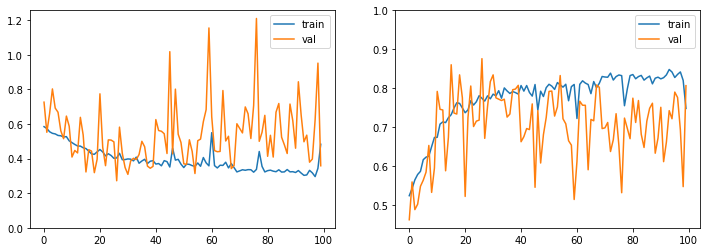

In [22]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5969 - accuracy: 0.6430 - precision: 0.9103 - recall: 0.6189 - f1: 0.7278 - specificity: 0.7343 - negative_predictive_value: 0.3312 - matthews_correlation_coefficient: 0.2905 - val_loss: 0.6241 - val_accuracy: 0.6305 - val_precision: 0.8792 - val_recall: 0.5864 - val_f1: 0.6973 - val_specificity: 0.7263 - val_negative_predictive_value: 0.3145 - val_matthews_correlation_coefficient: 0.2710

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.27098, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_15-19_22_34.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5770 - accuracy: 0.6777 - precision: 0.9062 - recall: 0.6689 - f1: 0.7630 - specificity: 0.7118 - negative_predictive_value: 0.3525 - matthews_correlation_coefficient: 0.3122 - val_loss: 0.5829 - val_accuracy: 0.6609 -

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5383 - accuracy: 0.7052 - precision: 0.9193 - recall: 0.6984 - f1: 0.7862 - specificity: 0.7431 - negative_predictive_value: 0.3867 - matthews_correlation_coefficient: 0.3648 - val_loss: 0.5462 - val_accuracy: 0.6678 - val_precision: 0.9003 - val_recall: 0.6162 - val_f1: 0.7256 - val_specificity: 0.8064 - val_negative_predictive_value: 0.3769 - val_matthews_correlation_coefficient: 0.3389

Epoch 00014: val_matthews_correlation_coefficient improved from 0.32902 to 0.33887, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_15-19_22_34.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5332 - accuracy: 0.6963 - precision: 0.9229 - recall: 0.6801 - f1: 0.7765 - specificity: 0.7635 - negative_predictive_value: 0.3801 - matthews_correlation_coefficient: 0.3647 - val_loss: 0.5578 - val_accuracy: 0.6618 - val_precision: 0.8984 - val_recall: 0.6090 - val_f1: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5153 - accuracy: 0.7191 - precision: 0.9292 - recall: 0.7107 - f1: 0.7976 - specificity: 0.7852 - negative_predictive_value: 0.4115 - matthews_correlation_coefficient: 0.4063 - val_loss: 0.5878 - val_accuracy: 0.6444 - val_precision: 0.9201 - val_recall: 0.5741 - val_f1: 0.7022 - val_specificity: 0.8646 - val_negative_predictive_value: 0.3602 - val_matthews_correlation_coefficient: 0.3475

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.38657
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5077 - accuracy: 0.7230 - precision: 0.9295 - recall: 0.7115 - f1: 0.7978 - specificity: 0.7647 - negative_predictive_value: 0.4070 - matthews_correlation_coefficient: 0.3969 - val_loss: 0.5063 - val_accuracy: 0.7086 - val_precision: 0.8957 - val_recall: 0.6748 - val_f1: 0.7658 - val_specificity: 0.7715 - val_negative_predictive_value: 0.4043 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4884 - accuracy: 0.7310 - precision: 0.9312 - recall: 0.7198 - f1: 0.8047 - specificity: 0.7967 - negative_predictive_value: 0.4209 - matthews_correlation_coefficient: 0.4237 - val_loss: 0.5693 - val_accuracy: 0.7095 - val_precision: 0.8981 - val_recall: 0.6745 - val_f1: 0.7655 - val_specificity: 0.7690 - val_negative_predictive_value: 0.4075 - val_matthews_correlation_coefficient: 0.3653

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.38657
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4838 - accuracy: 0.7354 - precision: 0.9315 - recall: 0.7280 - f1: 0.8102 - specificity: 0.7598 - negative_predictive_value: 0.4250 - matthews_correlation_coefficient: 0.4147 - val_loss: 0.4412 - val_accuracy: 0.7693 - val_precision: 0.8785 - val_recall: 0.7745 - val_f1: 0.8205 - val_specificity: 0.6701 - val_negative_predictive_value: 0.4694 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4754 - accuracy: 0.7499 - precision: 0.9315 - recall: 0.7444 - f1: 0.8213 - specificity: 0.7657 - negative_predictive_value: 0.4405 - matthews_correlation_coefficient: 0.4315 - val_loss: 0.5837 - val_accuracy: 0.6444 - val_precision: 0.9241 - val_recall: 0.5718 - val_f1: 0.7017 - val_specificity: 0.8833 - val_negative_predictive_value: 0.3625 - val_matthews_correlation_coefficient: 0.3581

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.41819
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4746 - accuracy: 0.7421 - precision: 0.9384 - recall: 0.7297 - f1: 0.8129 - specificity: 0.7957 - negative_predictive_value: 0.4399 - matthews_correlation_coefficient: 0.4406 - val_loss: 0.4736 - val_accuracy: 0.7233 - val_precision: 0.8962 - val_recall: 0.6969 - val_f1: 0.7804 - val_specificity: 0.7649 - val_negative_predictive_value: 0.4202 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4543 - accuracy: 0.7590 - precision: 0.9339 - recall: 0.7444 - f1: 0.8241 - specificity: 0.8019 - negative_predictive_value: 0.4486 - matthews_correlation_coefficient: 0.4602 - val_loss: 0.5198 - val_accuracy: 0.6990 - val_precision: 0.8946 - val_recall: 0.6662 - val_f1: 0.7600 - val_specificity: 0.7694 - val_negative_predictive_value: 0.3923 - val_matthews_correlation_coefficient: 0.3505

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.41819
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4602 - accuracy: 0.7555 - precision: 0.9347 - recall: 0.7497 - f1: 0.8250 - specificity: 0.7898 - negative_predictive_value: 0.4507 - matthews_correlation_coefficient: 0.4505 - val_loss: 0.5706 - val_accuracy: 0.6609 - val_precision: 0.9207 - val_recall: 0.5961 - val_f1: 0.7167 - val_specificity: 0.8598 - val_negative_predictive_value: 0.3773 - val_matthews_correlation_coefficie

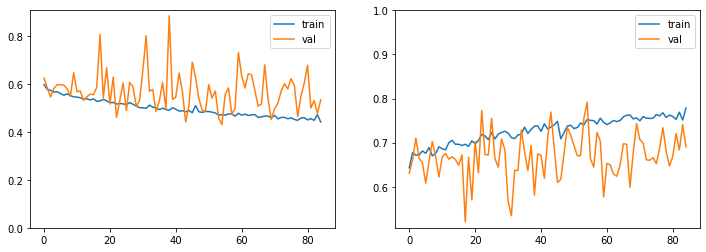

In [23]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6086 - accuracy: 0.7540 - precision: 0.9971 - recall: 0.7569 - f1: 0.8484 - specificity: 0.0862 - negative_predictive_value: 0.0176 - matthews_correlation_coefficient: 0.0274 - val_loss: 0.2150 - val_accuracy: 0.9688 - val_precision: 0.9974 - val_recall: 0.9720 - val_f1: 0.9844 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0676 - val_matthews_correlation_coefficient: 0.0699

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.06986, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_15-19_35_17.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5449 - accuracy: 0.6696 - precision: 0.9980 - recall: 0.6719 - f1: 0.7869 - specificity: 0.1034 - negative_predictive_value: 0.0101 - matthews_correlation_coefficient: 0.0216 - val_loss: 0.3771 - val_accuracy: 0.6834 - val_prec


Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.06986
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4000 - accuracy: 0.7033 - precision: 0.9994 - recall: 0.7009 - f1: 0.8215 - specificity: 0.1517 - negative_predictive_value: 0.0159 - matthews_correlation_coefficient: 0.0396 - val_loss: 0.5509 - val_accuracy: 0.6418 - val_precision: 0.9730 - val_recall: 0.6232 - val_f1: 0.7575 - val_specificity: 0.1622 - val_negative_predictive_value: 0.0140 - val_matthews_correlation_coefficient: 0.0382

Epoch 00016: val_matthews_correlation_coefficient did not improve from 0.06986
Epoch 17/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4208 - accuracy: 0.6640 - precision: 0.9990 - recall: 0.6619 - f1: 0.7921 - specificity: 0.1276 - negative_predictive_value: 0.0145 - matthews_correlation_coefficient: 0.0325 - val_loss: 0.5088 - val_accuracy: 0.6756 - val_precision: 0.9730 - val_recall: 0.6562 - val_f1: 0.7814 - val_spe


Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.06986
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3561 - accuracy: 0.8210 - precision: 0.9988 - recall: 0.8224 - f1: 0.8971 - specificity: 0.1241 - negative_predictive_value: 0.0307 - matthews_correlation_coefficient: 0.0502 - val_loss: 0.1698 - val_accuracy: 0.9462 - val_precision: 0.9982 - val_recall: 0.9490 - val_f1: 0.9724 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0383 - val_matthews_correlation_coefficient: 0.0597
Restoring model weights from the end of the best epoch

Epoch 00031: val_matthews_correlation_coefficient did not improve from 0.06986
Epoch 00031: early stopping

   Final Accuracy:  96.88%
  Final Precision:  99.73%
     Final Recall:  97.12%
  Final F-measure:  98.41%
Final Specificity:  50.00%
        Final NPV:   8.33%
        Final MCC:  19.49%
[[   3    3]
 [  33 1114]]
              precision    recall  f1-score   support

           0 

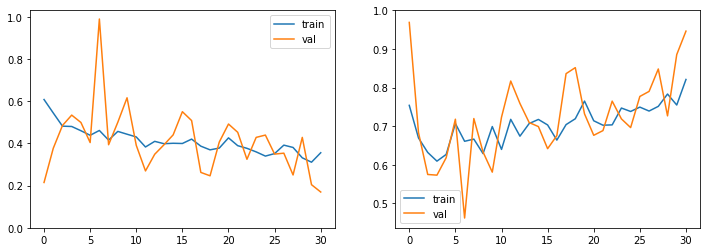

In [24]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 35s 8ms/step - loss: 0.6127 - accuracy: 0.6531 - precision: 0.8514 - recall: 0.6219 - f1: 0.7042 - specificity: 0.7292 - negative_predictive_value: 0.4494 - matthews_correlation_coefficient: 0.3258 - val_loss: 0.6662 - val_accuracy: 0.5490 - val_precision: 0.9101 - val_recall: 0.4154 - val_f1: 0.5601 - val_specificity: 0.8866 - val_negative_predictive_value: 0.3731 - val_matthews_correlation_coefficient: 0.2899

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28988, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_15-19_40_38.h5
Epoch 2/100
4610/4610 [==============================] - 50s 11ms/step - loss: 0.6063 - accuracy: 0.6508 - precision: 0.8683 - recall: 0.6127 - f1: 0.7038 - specificity: 0.7568 - negative_predictive_value: 0.4481 - matthews_correlation_coefficient: 0.3402 - val_loss: 0.5379 - val_accuracy: 0.6843 - val


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.39454
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5738 - accuracy: 0.6839 - precision: 0.8691 - recall: 0.6550 - f1: 0.7406 - specificity: 0.7648 - negative_predictive_value: 0.4720 - matthews_correlation_coefficient: 0.3787 - val_loss: 0.5763 - val_accuracy: 0.6956 - val_precision: 0.8736 - val_recall: 0.6710 - val_f1: 0.7522 - val_specificity: 0.7526 - val_negative_predictive_value: 0.4787 - val_matthews_correlation_coefficient: 0.3846

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.39454
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5737 - accuracy: 0.6820 - precision: 0.8774 - recall: 0.6377 - f1: 0.7320 - specificity: 0.7859 - negative_predictive_value: 0.4693 - matthews_correlation_coefficient: 0.3882 - val_loss: 0.5694 - val_accuracy: 0.6930 - val_precision: 0.8776 - val_recall: 0.6640 - val_f1: 0.7498 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5626 - accuracy: 0.6772 - precision: 0.8918 - recall: 0.6207 - f1: 0.7225 - specificity: 0.8031 - negative_predictive_value: 0.4643 - matthews_correlation_coefficient: 0.3877 - val_loss: 0.5000 - val_accuracy: 0.7103 - val_precision: 0.8499 - val_recall: 0.7267 - val_f1: 0.7791 - val_specificity: 0.6757 - val_negative_predictive_value: 0.4946 - val_matthews_correlation_coefficient: 0.3707

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.42861
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5568 - accuracy: 0.6918 - precision: 0.8906 - recall: 0.6511 - f1: 0.7447 - specificity: 0.7939 - negative_predictive_value: 0.4850 - matthews_correlation_coefficient: 0.4087 - val_loss: 0.5756 - val_accuracy: 0.6635 - val_precision: 0.9237 - val_recall: 0.5838 - val_f1: 0.7042 - val_specificity: 0.8644 - val_negative_predictive_value: 0.4549 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.43450
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5350 - accuracy: 0.6998 - precision: 0.8972 - recall: 0.6513 - f1: 0.7481 - specificity: 0.8044 - negative_predictive_value: 0.4886 - matthews_correlation_coefficient: 0.4192 - val_loss: 0.5307 - val_accuracy: 0.6982 - val_precision: 0.8891 - val_recall: 0.6630 - val_f1: 0.7515 - val_specificity: 0.7867 - val_negative_predictive_value: 0.4831 - val_matthews_correlation_coefficient: 0.4073

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.43450
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5336 - accuracy: 0.7002 - precision: 0.8985 - recall: 0.6447 - f1: 0.7440 - specificity: 0.8277 - negative_predictive_value: 0.4923 - matthews_correlation_coefficient: 0.4349 - val_loss: 0.5133 - val_accuracy: 0.7173 - val_precision: 0.8919 - val_recall: 0.6904 - val_f1: 0.7715 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5273 - accuracy: 0.7030 - precision: 0.9035 - recall: 0.6567 - f1: 0.7536 - specificity: 0.8311 - negative_predictive_value: 0.5031 - matthews_correlation_coefficient: 0.4440 - val_loss: 0.5637 - val_accuracy: 0.6834 - val_precision: 0.9281 - val_recall: 0.6108 - val_f1: 0.7261 - val_specificity: 0.8641 - val_negative_predictive_value: 0.4699 - val_matthews_correlation_coefficient: 0.4316

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.44621
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5285 - accuracy: 0.7037 - precision: 0.9033 - recall: 0.6575 - f1: 0.7546 - specificity: 0.8077 - negative_predictive_value: 0.4898 - matthews_correlation_coefficient: 0.4264 - val_loss: 0.5139 - val_accuracy: 0.7173 - val_precision: 0.9029 - val_recall: 0.6875 - val_f1: 0.7718 - val_specificity: 0.7919 - val_negative_predictive_value: 0.5018 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5237 - accuracy: 0.7030 - precision: 0.9083 - recall: 0.6548 - f1: 0.7528 - specificity: 0.8317 - negative_predictive_value: 0.5041 - matthews_correlation_coefficient: 0.4461 - val_loss: 0.5265 - val_accuracy: 0.7103 - val_precision: 0.8951 - val_recall: 0.6769 - val_f1: 0.7641 - val_specificity: 0.7926 - val_negative_predictive_value: 0.4910 - val_matthews_correlation_coefficient: 0.4238

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.45286
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5197 - accuracy: 0.7191 - precision: 0.9055 - recall: 0.6769 - f1: 0.7690 - specificity: 0.8173 - negative_predictive_value: 0.5075 - matthews_correlation_coefficient: 0.4515 - val_loss: 0.5122 - val_accuracy: 0.7216 - val_precision: 0.9036 - val_recall: 0.6870 - val_f1: 0.7731 - val_specificity: 0.8050 - val_negative_predictive_value: 0.5075 - val_matthews_correlation_coefficie


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.47058
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5095 - accuracy: 0.7182 - precision: 0.9067 - recall: 0.6740 - f1: 0.7651 - specificity: 0.8257 - negative_predictive_value: 0.5070 - matthews_correlation_coefficient: 0.4541 - val_loss: 0.5051 - val_accuracy: 0.7129 - val_precision: 0.9188 - val_recall: 0.6593 - val_f1: 0.7588 - val_specificity: 0.8473 - val_negative_predictive_value: 0.4995 - val_matthews_correlation_coefficient: 0.4579

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.47058
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5106 - accuracy: 0.7156 - precision: 0.9094 - recall: 0.6675 - f1: 0.7636 - specificity: 0.8414 - negative_predictive_value: 0.5123 - matthews_correlation_coefficient: 0.4609 - val_loss: 0.5188 - val_accuracy: 0.7190 - val_precision: 0.9146 - val_recall: 0.6735 - val_f1: 0.7667 - val_spe

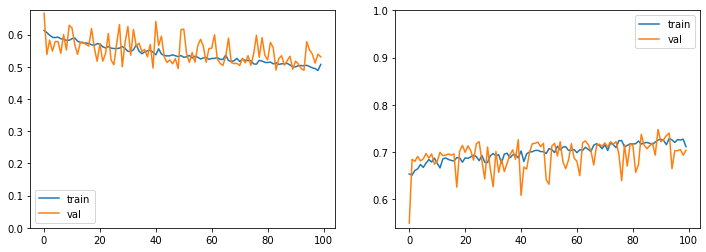

In [25]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6013 - accuracy: 0.5974 - precision: 0.9314 - recall: 0.5801 - f1: 0.7030 - specificity: 0.7284 - negative_predictive_value: 0.2300 - matthews_correlation_coefficient: 0.2190 - val_loss: 0.4364 - val_accuracy: 0.7884 - val_precision: 0.8737 - val_recall: 0.8279 - val_f1: 0.8479 - val_specificity: 0.4106 - val_negative_predictive_value: 0.3216 - val_matthews_correlation_coefficient: 0.2384

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.23841, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_15-19_56_59.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5618 - accuracy: 0.6293 - precision: 0.9468 - recall: 0.6081 - f1: 0.7275 - specificity: 0.7656 - negative_predictive_value: 0.2641 - matthews_correlation_coefficient: 0.2798 - val_loss: 0.4880 - val_accuracy: 0.7077 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.37109
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5411 - accuracy: 0.6334 - precision: 0.9460 - recall: 0.6014 - f1: 0.7166 - specificity: 0.8298 - negative_predictive_value: 0.2774 - matthews_correlation_coefficient: 0.3131 - val_loss: 0.4297 - val_accuracy: 0.7806 - val_precision: 0.9234 - val_recall: 0.7662 - val_f1: 0.8348 - val_specificity: 0.7313 - val_negative_predictive_value: 0.3560 - val_matthews_correlation_coefficient: 0.3931

Epoch 00015: val_matthews_correlation_coefficient improved from 0.37109 to 0.39311, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_15-19_56_59.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4752 - accuracy: 0.7230 - precision: 0.9533 - recall: 0.7114 - f1: 0.8093 - specificity: 0.7997 - negative_predictive_value: 0.3236 - matthews_correlation_coefficient: 0.3754 - val_loss: 0.4478 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4410 - accuracy: 0.7412 - precision: 0.9592 - recall: 0.7320 - f1: 0.8265 - specificity: 0.7856 - negative_predictive_value: 0.3323 - matthews_correlation_coefficient: 0.3827 - val_loss: 0.3712 - val_accuracy: 0.7936 - val_precision: 0.9485 - val_recall: 0.8105 - val_f1: 0.8710 - val_specificity: 0.7063 - val_negative_predictive_value: 0.3743 - val_matthews_correlation_coefficient: 0.3998

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.44704
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4344 - accuracy: 0.7447 - precision: 0.9627 - recall: 0.7341 - f1: 0.8281 - specificity: 0.8154 - negative_predictive_value: 0.3498 - matthews_correlation_coefficient: 0.4083 - val_loss: 0.3491 - val_accuracy: 0.8057 - val_precision: 0.9404 - val_recall: 0.8317 - val_f1: 0.8805 - val_specificity: 0.6675 - val_negative_predictive_value: 0.3865 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4188 - accuracy: 0.7555 - precision: 0.9645 - recall: 0.7421 - f1: 0.8334 - specificity: 0.8293 - negative_predictive_value: 0.3588 - matthews_correlation_coefficient: 0.4239 - val_loss: 0.3458 - val_accuracy: 0.8014 - val_precision: 0.9280 - val_recall: 0.8387 - val_f1: 0.8794 - val_specificity: 0.5794 - val_negative_predictive_value: 0.3691 - val_matthews_correlation_coefficient: 0.3465

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.44704
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4197 - accuracy: 0.7488 - precision: 0.9648 - recall: 0.7358 - f1: 0.8290 - specificity: 0.8328 - negative_predictive_value: 0.3514 - matthews_correlation_coefficient: 0.4172 - val_loss: 0.3643 - val_accuracy: 0.8023 - val_precision: 0.9427 - val_recall: 0.8251 - val_f1: 0.8780 - val_specificity: 0.6957 - val_negative_predictive_value: 0.3873 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.45961
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4197 - accuracy: 0.7657 - precision: 0.9634 - recall: 0.7582 - f1: 0.8446 - specificity: 0.8260 - negative_predictive_value: 0.3693 - matthews_correlation_coefficient: 0.4327 - val_loss: 0.3494 - val_accuracy: 0.8196 - val_precision: 0.9394 - val_recall: 0.8505 - val_f1: 0.8904 - val_specificity: 0.6496 - val_negative_predictive_value: 0.4270 - val_matthews_correlation_coefficient: 0.4189

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.45961
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4083 - accuracy: 0.7761 - precision: 0.9642 - recall: 0.7654 - f1: 0.8493 - specificity: 0.8342 - negative_predictive_value: 0.3830 - matthews_correlation_coefficient: 0.4498 - val_loss: 0.3516 - val_accuracy: 0.8161 - val_precision: 0.9568 - val_recall: 0.8297 - val_f1: 0.8859 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.49690
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4707 - accuracy: 0.7406 - precision: 0.9562 - recall: 0.7323 - f1: 0.8072 - specificity: 0.7668 - negative_predictive_value: 0.3614 - matthews_correlation_coefficient: 0.3900 - val_loss: 0.3419 - val_accuracy: 0.8309 - val_precision: 0.9439 - val_recall: 0.8589 - val_f1: 0.8975 - val_specificity: 0.6641 - val_negative_predictive_value: 0.4385 - val_matthews_correlation_coefficient: 0.4404

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.49690
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4057 - accuracy: 0.7785 - precision: 0.9599 - recall: 0.7739 - f1: 0.8518 - specificity: 0.8294 - negative_predictive_value: 0.3856 - matthews_correlation_coefficient: 0.4514 - val_loss: 0.3125 - val_accuracy: 0.8552 - val_precision: 0.9479 - val_recall: 0.8843 - val_f1: 0.9131 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.49690
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3752 - accuracy: 0.8022 - precision: 0.9708 - recall: 0.7959 - f1: 0.8708 - specificity: 0.8393 - negative_predictive_value: 0.4207 - matthews_correlation_coefficient: 0.4915 - val_loss: 0.3206 - val_accuracy: 0.8335 - val_precision: 0.9523 - val_recall: 0.8555 - val_f1: 0.8985 - val_specificity: 0.6870 - val_negative_predictive_value: 0.4577 - val_matthews_correlation_coefficient: 0.4590

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.49690
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3750 - accuracy: 0.7937 - precision: 0.9669 - recall: 0.7885 - f1: 0.8644 - specificity: 0.8407 - negative_predictive_value: 0.4125 - matthews_correlation_coefficient: 0.4801 - val_loss: 0.2752 - val_accuracy: 0.8786 - val_precision: 0.9151 - val_recall: 0.9504 - val_f1: 0.9311 - val_spe

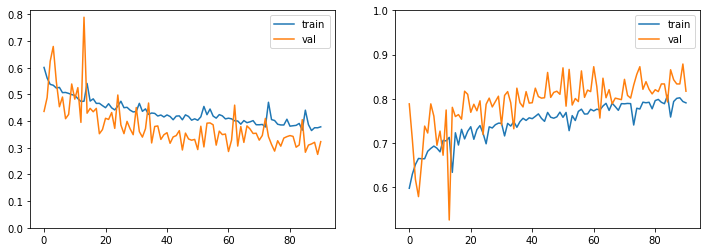

In [26]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.3929 - accuracy: 0.7948 - precision: 0.9927 - recall: 0.7854 - f1: 0.8712 - specificity: 0.7888 - negative_predictive_value: 0.2398 - matthews_correlation_coefficient: 0.3664 - val_loss: 0.3122 - val_accuracy: 0.8543 - val_precision: 0.9641 - val_recall: 0.8299 - val_f1: 0.8910 - val_specificity: 0.7680 - val_negative_predictive_value: 0.2764 - val_matthews_correlation_coefficient: 0.4003

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.40029, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_15-20_10_46.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3120 - accuracy: 0.8798 - precision: 0.9924 - recall: 0.8769 - f1: 0.9291 - specificity: 0.7325 - negative_predictive_value: 0.3356 - matthews_correlation_coefficient: 0.4440 - val_loss: 0.3676 - val_accuracy: 0.8621 - val_precis

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2275 - accuracy: 0.9104 - precision: 0.9922 - recall: 0.9092 - f1: 0.9472 - specificity: 0.7834 - negative_predictive_value: 0.4289 - matthews_correlation_coefficient: 0.5339 - val_loss: 0.2617 - val_accuracy: 0.9107 - val_precision: 0.9650 - val_recall: 0.8882 - val_f1: 0.9245 - val_specificity: 0.7680 - val_negative_predictive_value: 0.3626 - val_matthews_correlation_coefficient: 0.4837

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.51076
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2341 - accuracy: 0.9195 - precision: 0.9857 - recall: 0.9151 - f1: 0.9481 - specificity: 0.7778 - negative_predictive_value: 0.4338 - matthews_correlation_coefficient: 0.5387 - val_loss: 0.2663 - val_accuracy: 0.9133 - val_precision: 0.9651 - val_recall: 0.8911 - val_f1: 0.9261 - val_specificity: 0.7680 - val_negative_predictive_value: 0.3816 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2059 - accuracy: 0.9243 - precision: 0.9941 - recall: 0.9256 - f1: 0.9577 - specificity: 0.7545 - negative_predictive_value: 0.4491 - matthews_correlation_coefficient: 0.5410 - val_loss: 0.1607 - val_accuracy: 0.9480 - val_precision: 0.9916 - val_recall: 0.9539 - val_f1: 0.9720 - val_specificity: 0.7545 - val_negative_predictive_value: 0.5019 - val_matthews_correlation_coefficient: 0.5802

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.60351
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2164 - accuracy: 0.9252 - precision: 0.9889 - recall: 0.9285 - f1: 0.9561 - specificity: 0.7896 - negative_predictive_value: 0.4656 - matthews_correlation_coefficient: 0.5616 - val_loss: 0.3587 - val_accuracy: 0.8829 - val_precision: 0.9647 - val_recall: 0.8597 - val_f1: 0.9085 - val_specificity: 0.7680 - val_negative_predictive_value: 0.3144 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.61654
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1867 - accuracy: 0.9369 - precision: 0.9944 - recall: 0.9379 - f1: 0.9643 - specificity: 0.7863 - negative_predictive_value: 0.5058 - matthews_correlation_coefficient: 0.5917 - val_loss: 0.1660 - val_accuracy: 0.9497 - val_precision: 0.9935 - val_recall: 0.9539 - val_f1: 0.9729 - val_specificity: 0.7725 - val_negative_predictive_value: 0.5068 - val_matthews_correlation_coefficient: 0.5946

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.61654
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1671 - accuracy: 0.9397 - precision: 0.9950 - recall: 0.9411 - f1: 0.9665 - specificity: 0.8205 - negative_predictive_value: 0.5140 - matthews_correlation_coefficient: 0.6113 - val_loss: 0.1323 - val_accuracy: 0.9558 - val_precision: 0.9936 - val_recall: 0.9603 - val_f1: 0.9763 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1333 - accuracy: 0.9588 - precision: 0.9960 - recall: 0.9570 - f1: 0.9751 - specificity: 0.7917 - negative_predictive_value: 0.5972 - matthews_correlation_coefficient: 0.6597 - val_loss: 0.0930 - val_accuracy: 0.9653 - val_precision: 0.9954 - val_recall: 0.9684 - val_f1: 0.9815 - val_specificity: 0.7928 - val_negative_predictive_value: 0.5986 - val_matthews_correlation_coefficient: 0.6629

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.68337
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1473 - accuracy: 0.9510 - precision: 0.9950 - recall: 0.9499 - f1: 0.9707 - specificity: 0.8383 - negative_predictive_value: 0.5974 - matthews_correlation_coefficient: 0.6715 - val_loss: 0.4243 - val_accuracy: 0.8742 - val_precision: 0.9687 - val_recall: 0.8472 - val_f1: 0.9033 - val_specificity: 0.8063 - val_negative_predictive_value: 0.3053 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1339 - accuracy: 0.9555 - precision: 0.9955 - recall: 0.9574 - f1: 0.9754 - specificity: 0.8289 - negative_predictive_value: 0.5974 - matthews_correlation_coefficient: 0.6708 - val_loss: 0.1908 - val_accuracy: 0.9306 - val_precision: 0.9662 - val_recall: 0.9081 - val_f1: 0.9359 - val_specificity: 0.7770 - val_negative_predictive_value: 0.4279 - val_matthews_correlation_coefficient: 0.5419

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.68575
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1472 - accuracy: 0.9471 - precision: 0.9955 - recall: 0.9485 - f1: 0.9706 - specificity: 0.8287 - negative_predictive_value: 0.5602 - matthews_correlation_coefficient: 0.6432 - val_loss: 0.0851 - val_accuracy: 0.9705 - val_precision: 0.9928 - val_recall: 0.9765 - val_f1: 0.9842 - val_specificity: 0.7671 - val_negative_predictive_value: 0.6455 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.72025
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1144 - accuracy: 0.9527 - precision: 0.9969 - recall: 0.9499 - f1: 0.9716 - specificity: 0.8463 - negative_predictive_value: 0.5860 - matthews_correlation_coefficient: 0.6717 - val_loss: 0.1858 - val_accuracy: 0.9176 - val_precision: 0.9691 - val_recall: 0.8920 - val_f1: 0.9283 - val_specificity: 0.8099 - val_negative_predictive_value: 0.4230 - val_matthews_correlation_coefficient: 0.5423

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.72025
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1294 - accuracy: 0.9562 - precision: 0.9966 - recall: 0.9566 - f1: 0.9755 - specificity: 0.8052 - negative_predictive_value: 0.6031 - matthews_correlation_coefficient: 0.6693 - val_loss: 0.2382 - val_accuracy: 0.8959 - val_precision: 0.9709 - val_recall: 0.8676 - val_f1: 0.9156 - val_spe

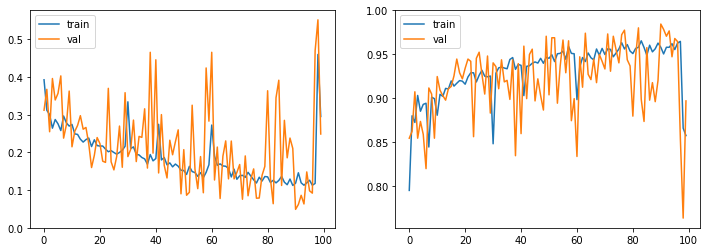

In [27]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6104 - accuracy: 0.6384 - precision: 0.8644 - recall: 0.5980 - f1: 0.6949 - specificity: 0.7414 - negative_predictive_value: 0.4094 - matthews_correlation_coefficient: 0.3034 - val_loss: 0.6939 - val_accuracy: 0.6010 - val_precision: 0.8605 - val_recall: 0.5115 - val_f1: 0.6338 - val_specificity: 0.8158 - val_negative_predictive_value: 0.4076 - val_matthews_correlation_coefficient: 0.2951

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29508, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_15-20_25_48.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5901 - accuracy: 0.6599 - precision: 0.8787 - recall: 0.6274 - f1: 0.7219 - specificity: 0.7488 - negative_predictive_value: 0.4255 - matthews_correlation_coefficient: 0.3379 - val_loss: 0.6275 - val_accuracy: 0.6444 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5504 - accuracy: 0.6844 - precision: 0.8834 - recall: 0.6443 - f1: 0.7405 - specificity: 0.7872 - negative_predictive_value: 0.4532 - matthews_correlation_coefficient: 0.3813 - val_loss: 0.5459 - val_accuracy: 0.6756 - val_precision: 0.8587 - val_recall: 0.6301 - val_f1: 0.7212 - val_specificity: 0.7669 - val_negative_predictive_value: 0.4586 - val_matthews_correlation_coefficient: 0.3536

Epoch 00015: val_matthews_correlation_coefficient improved from 0.35124 to 0.35358, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_15-20_25_48.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5445 - accuracy: 0.6944 - precision: 0.8891 - recall: 0.6550 - f1: 0.7484 - specificity: 0.7821 - negative_predictive_value: 0.4627 - matthews_correlation_coefficient: 0.3972 - val_loss: 0.6498 - val_accuracy: 0.6184 - val_precision: 0.8720 - val_recall: 0.5289 - val_f1: 0.6525 - val_speci

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5398 - accuracy: 0.7035 - precision: 0.8931 - recall: 0.6771 - f1: 0.7647 - specificity: 0.7696 - negative_predictive_value: 0.4711 - matthews_correlation_coefficient: 0.4030 - val_loss: 0.5542 - val_accuracy: 0.6730 - val_precision: 0.8684 - val_recall: 0.6159 - val_f1: 0.7154 - val_specificity: 0.7951 - val_negative_predictive_value: 0.4583 - val_matthews_correlation_coefficient: 0.3651

Epoch 00029: val_matthews_correlation_coefficient improved from 0.35887 to 0.36506, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_15-20_25_48.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5328 - accuracy: 0.7069 - precision: 0.8961 - recall: 0.6765 - f1: 0.7653 - specificity: 0.7866 - negative_predictive_value: 0.4768 - matthews_correlation_coefficient: 0.4150 - val_loss: 0.6011 - val_accuracy: 0.6565 - val_precision: 0.8708 - val_recall: 0.5884 - val_f1: 0.6970 - val_speci


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.36564
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5258 - accuracy: 0.7043 - precision: 0.8972 - recall: 0.6648 - f1: 0.7584 - specificity: 0.8022 - negative_predictive_value: 0.4724 - matthews_correlation_coefficient: 0.4200 - val_loss: 0.5817 - val_accuracy: 0.6583 - val_precision: 0.8713 - val_recall: 0.5901 - val_f1: 0.6985 - val_specificity: 0.8129 - val_negative_predictive_value: 0.4470 - val_matthews_correlation_coefficient: 0.3568

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.36564
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5226 - accuracy: 0.7015 - precision: 0.8984 - recall: 0.6576 - f1: 0.7536 - specificity: 0.8137 - negative_predictive_value: 0.4724 - matthews_correlation_coefficient: 0.4233 - val_loss: 0.6009 - val_accuracy: 0.6487 - val_precision: 0.8806 - val_recall: 0.5671 - val_f1: 0.6856 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5206 - accuracy: 0.7056 - precision: 0.9007 - recall: 0.6739 - f1: 0.7633 - specificity: 0.7930 - negative_predictive_value: 0.4762 - matthews_correlation_coefficient: 0.4185 - val_loss: 0.5567 - val_accuracy: 0.6765 - val_precision: 0.8625 - val_recall: 0.6264 - val_f1: 0.7209 - val_specificity: 0.7856 - val_negative_predictive_value: 0.4590 - val_matthews_correlation_coefficient: 0.3621

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.36809
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5115 - accuracy: 0.7187 - precision: 0.9005 - recall: 0.6921 - f1: 0.7769 - specificity: 0.7821 - negative_predictive_value: 0.4876 - matthews_correlation_coefficient: 0.4284 - val_loss: 0.5155 - val_accuracy: 0.6912 - val_precision: 0.8482 - val_recall: 0.6647 - val_f1: 0.7404 - val_specificity: 0.7400 - val_negative_predictive_value: 0.4772 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.36930
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5011 - accuracy: 0.7221 - precision: 0.9052 - recall: 0.6836 - f1: 0.7740 - specificity: 0.8093 - negative_predictive_value: 0.4883 - matthews_correlation_coefficient: 0.4385 - val_loss: 0.5191 - val_accuracy: 0.6973 - val_precision: 0.8582 - val_recall: 0.6634 - val_f1: 0.7433 - val_specificity: 0.7650 - val_negative_predictive_value: 0.4808 - val_matthews_correlation_coefficient: 0.3790

Epoch 00073: val_matthews_correlation_coefficient improved from 0.36930 to 0.37902, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_15-20_25_48.h5
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5063 - accuracy: 0.7076 - precision: 0.9089 - recall: 0.6679 - f1: 0.7637 - specificity: 0.8091 - negative_predictive_value: 0.4764 - matthews_correlation_coefficient: 0.4280 - val_loss: 0.5067 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4989 - accuracy: 0.7215 - precision: 0.8947 - recall: 0.6920 - f1: 0.7745 - specificity: 0.7878 - negative_predictive_value: 0.4905 - matthews_correlation_coefficient: 0.4341 - val_loss: 0.5351 - val_accuracy: 0.6782 - val_precision: 0.8532 - val_recall: 0.6367 - val_f1: 0.7245 - val_specificity: 0.7650 - val_negative_predictive_value: 0.4613 - val_matthews_correlation_coefficient: 0.3537

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.38539
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4932 - accuracy: 0.7245 - precision: 0.9091 - recall: 0.6953 - f1: 0.7819 - specificity: 0.8182 - negative_predictive_value: 0.5008 - matthews_correlation_coefficient: 0.4565 - val_loss: 0.5456 - val_accuracy: 0.6834 - val_precision: 0.8627 - val_recall: 0.6365 - val_f1: 0.7275 - val_specificity: 0.7852 - val_negative_predictive_value: 0.4697 - val_matthews_correlation_coefficie

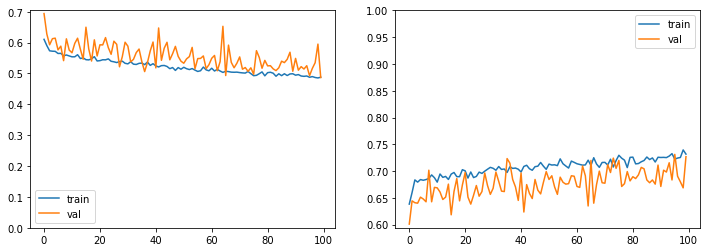

In [28]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4621 - accuracy: 0.7885 - precision: 0.9967 - recall: 0.7887 - f1: 0.8738 - specificity: 0.4115 - negative_predictive_value: 0.0870 - matthews_correlation_coefficient: 0.1585 - val_loss: 0.6970 - val_accuracy: 0.6860 - val_precision: 0.9975 - val_recall: 0.6901 - val_f1: 0.8122 - val_specificity: 0.4324 - val_negative_predictive_value: 0.0475 - val_matthews_correlation_coefficient: 0.1103

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.11035, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_15-20_40_56.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3966 - accuracy: 0.8456 - precision: 0.9975 - recall: 0.8457 - f1: 0.9140 - specificity: 0.3713 - negative_predictive_value: 0.0876 - matthews_correlation_coefficient: 0.1576 - val_loss: 0.3185 - val_accuracy: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3349 - accuracy: 0.8403 - precision: 0.9979 - recall: 0.8402 - f1: 0.9111 - specificity: 0.3966 - negative_predictive_value: 0.0948 - matthews_correlation_coefficient: 0.1667 - val_loss: 0.3888 - val_accuracy: 0.8621 - val_precision: 0.9981 - val_recall: 0.8648 - val_f1: 0.9249 - val_specificity: 0.4324 - val_negative_predictive_value: 0.1147 - val_matthews_correlation_coefficient: 0.1939

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.20913
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3308 - accuracy: 0.8553 - precision: 0.9979 - recall: 0.8553 - f1: 0.9202 - specificity: 0.4310 - negative_predictive_value: 0.1075 - matthews_correlation_coefficient: 0.1908 - val_loss: 0.2396 - val_accuracy: 0.8820 - val_precision: 0.9982 - val_recall: 0.8846 - val_f1: 0.9365 - val_specificity: 0.4324 - val_negative_predictive_value: 0.1295 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.21317
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2934 - accuracy: 0.8529 - precision: 0.9979 - recall: 0.8529 - f1: 0.9186 - specificity: 0.4345 - negative_predictive_value: 0.1111 - matthews_correlation_coefficient: 0.1938 - val_loss: 0.2838 - val_accuracy: 0.8708 - val_precision: 0.9981 - val_recall: 0.8734 - val_f1: 0.9299 - val_specificity: 0.4324 - val_negative_predictive_value: 0.1220 - val_matthews_correlation_coefficient: 0.2018

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.21317
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2920 - accuracy: 0.8640 - precision: 0.9982 - recall: 0.8641 - f1: 0.9255 - specificity: 0.4092 - negative_predictive_value: 0.1195 - matthews_correlation_coefficient: 0.1996 - val_loss: 0.2754 - val_accuracy: 0.8829 - val_precision: 0.9981 - val_recall: 0.8855 - val_f1: 0.9369 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.21394
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2771 - accuracy: 0.8681 - precision: 0.9977 - recall: 0.8654 - f1: 0.9254 - specificity: 0.4115 - negative_predictive_value: 0.1171 - matthews_correlation_coefficient: 0.1972 - val_loss: 0.4856 - val_accuracy: 0.8135 - val_precision: 1.0000 - val_recall: 0.8150 - val_f1: 0.8955 - val_specificity: 0.4865 - val_negative_predictive_value: 0.0912 - val_matthews_correlation_coefficient: 0.1860

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.21394
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2694 - accuracy: 0.8644 - precision: 0.9992 - recall: 0.8635 - f1: 0.9254 - specificity: 0.4276 - negative_predictive_value: 0.1167 - matthews_correlation_coefficient: 0.2026 - val_loss: 0.2768 - val_accuracy: 0.8708 - val_precision: 0.9981 - val_recall: 0.8734 - val_f1: 0.9299 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.22381
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2922 - accuracy: 0.8683 - precision: 0.9956 - recall: 0.8681 - f1: 0.9255 - specificity: 0.4276 - negative_predictive_value: 0.1247 - matthews_correlation_coefficient: 0.2098 - val_loss: 0.3783 - val_accuracy: 0.8526 - val_precision: 0.9990 - val_recall: 0.8545 - val_f1: 0.9193 - val_specificity: 0.4595 - val_negative_predictive_value: 0.1099 - val_matthews_correlation_coefficient: 0.2004

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.22381
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3664 - accuracy: 0.7920 - precision: 0.9987 - recall: 0.7910 - f1: 0.8744 - specificity: 0.4345 - negative_predictive_value: 0.0984 - matthews_correlation_coefficient: 0.1784 - val_loss: 0.4283 - val_accuracy: 0.8543 - val_precision: 0.9990 - val_recall: 0.8562 - val_f1: 0.9202 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.22719
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2611 - accuracy: 0.8620 - precision: 0.9987 - recall: 0.8615 - f1: 0.9240 - specificity: 0.4448 - negative_predictive_value: 0.1163 - matthews_correlation_coefficient: 0.2036 - val_loss: 0.3351 - val_accuracy: 0.8474 - val_precision: 0.9990 - val_recall: 0.8494 - val_f1: 0.9157 - val_specificity: 0.4595 - val_negative_predictive_value: 0.1226 - val_matthews_correlation_coefficient: 0.2071

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.22719
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2319 - accuracy: 0.8735 - precision: 0.9990 - recall: 0.8728 - f1: 0.9305 - specificity: 0.4736 - negative_predictive_value: 0.1259 - matthews_correlation_coefficient: 0.2193 - val_loss: 0.3532 - val_accuracy: 0.8517 - val_precision: 1.0000 - val_recall: 0.8529 - val_f1: 0.9185 - val_spe


Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.23192
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2358 - accuracy: 0.8725 - precision: 0.9992 - recall: 0.8717 - f1: 0.9300 - specificity: 0.4253 - negative_predictive_value: 0.1284 - matthews_correlation_coefficient: 0.2108 - val_loss: 0.2654 - val_accuracy: 0.8716 - val_precision: 0.9960 - val_recall: 0.8762 - val_f1: 0.9304 - val_specificity: 0.4189 - val_negative_predictive_value: 0.1343 - val_matthews_correlation_coefficient: 0.2078

Epoch 00090: val_matthews_correlation_coefficient did not improve from 0.23192
Epoch 91/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2384 - accuracy: 0.8748 - precision: 0.9988 - recall: 0.8743 - f1: 0.9313 - specificity: 0.4552 - negative_predictive_value: 0.1171 - matthews_correlation_coefficient: 0.2096 - val_loss: 0.3937 - val_accuracy: 0.8101 - val_precision: 0.9978 - val_recall: 0.8134 - val_f1: 0.8938 - val_spe

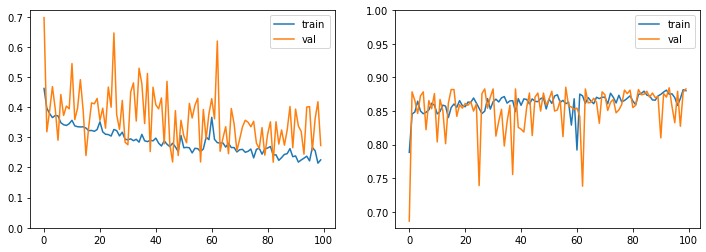

In [29]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [66]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [70]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_15-16_05_41.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_15-16_19_37.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_15-16_34_22.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_15-16_49_07.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_15-16_58_44.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_15-17_11_57.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_15-17_17_55.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_15-17_33_05.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_15-17_48_00.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_15-18_00_48.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_15-18_09_06.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_15-18_24_04.h5'
 '../models/autoencoders_requirements/shadows_behind_head_2020_03_15-18_37_54.h5'


In [71]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

In [78]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [79]:
final_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
final_model.summary()

final_model.save(f'{FOLDER_MODELS}final_model_{USER_IDS}.h5')

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [80]:
import cv2
from glob import glob

list_files = glob('../data/pybossa/images/*')
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = final_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images\FRGC_04575d123.jpg
1 of 1


[array([[0.9999752]], dtype=float32),
 array([[0.5412964]], dtype=float32),
 array([[0.36937243]], dtype=float32),
 array([[0.63088816]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.48232478]], dtype=float32),
 array([[0.86761415]], dtype=float32),
 array([[0.635293]], dtype=float32),
 array([[0.999979]], dtype=float32),
 array([[0.69606733]], dtype=float32),
 array([[0.5360229]], dtype=float32),
 array([[0.8295829]], dtype=float32),
 array([[0.98043525]], dtype=float32),
 array([[0.9444785]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9912759]], dtype=float32),
 array([[0.9847134]], dtype=float32),
 array([[0.93523467]], dtype=float32),
 array([[0.9507612]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.37819487]], dtype=float32),
 array([[1.]], dtype=float32)]